In [83]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [84]:
import collections
import math
import os
import random
import zipfile

In [85]:
from six.moves import urllib
from six.moves import xrange

In [86]:
import numpy as np
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

In [87]:
print(np.__version__)
print(tf.__version__)

1.20.1
2.3.0


In [88]:
DOWNLOADED_FILENAME = 'SampleText.zip'
def maybe_download(url_path, expected_bytes):
    if not os.path.exists(DOWNLOADED_FILENAME):
        filename, _ = urllib.request.urlretrieve(url_path, DOWNLOADED_FILENAME)
        
    statinfo = os.stat(DOWNLOADED_FILENAME)
    if statinfo.st_size == expected_bytes:
        print('Found and verified file from tis path: ', url_path)
        print('Downloaded file: ', DOWNLOADED_FILENAME)
    else:
        print(statinfo.st_size)
        raise Exception(
        'Failed to verify file from: ' + url_path + '. Can you get it with a browser?')

In [89]:
def read_words():
    with zipfile.ZipFile(DOWNLOADED_FILENAME) as f:
        firstfile = f.namelist()[0]
        filestring = tf.compat.as_str(f.read(firstfile))
        words = filestring.split()
    
    return words

In [90]:
URL_PATH = 'http://mattmahoney.net/dc/text8.zip'
FILESIZE = 31344016

maybe_download(URL_PATH, FILESIZE)

Found and verified file from tis path:  http://mattmahoney.net/dc/text8.zip
Downloaded file:  SampleText.zip


In [91]:
vocabulary = read_words()

In [92]:
vocabulary[:10]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against']

In [93]:
collections.Counter(vocabulary).most_common(5000 -1)

[('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430),
 ('two', 192644),
 ('is', 183153),
 ('as', 131815),
 ('eight', 125285),
 ('for', 118445),
 ('s', 116710),
 ('five', 115789),
 ('three', 114775),
 ('was', 112807),
 ('by', 111831),
 ('that', 109510),
 ('four', 108182),
 ('six', 102145),
 ('seven', 99683),
 ('with', 95603),
 ('on', 91250),
 ('are', 76527),
 ('it', 73334),
 ('from', 72871),
 ('or', 68945),
 ('his', 62603),
 ('an', 61925),
 ('be', 61281),
 ('this', 58832),
 ('which', 54788),
 ('at', 54576),
 ('he', 53573),
 ('also', 44358),
 ('not', 44033),
 ('have', 39712),
 ('were', 39086),
 ('has', 37866),
 ('but', 35358),
 ('other', 32433),
 ('their', 31523),
 ('its', 29567),
 ('first', 28810),
 ('they', 28553),
 ('some', 28161),
 ('had', 28100),
 ('all', 26229),
 ('more', 26223),
 ('most', 25563),
 ('can', 25519),
 ('been', 25383),
 ('such', 24413),
 ('many', 24096),
 ('who', 2

In [94]:
def build_dataset(words, n_words):
    word_counts = [['UNKNOWN', -1]]
    
    counter = collections.Counter(words)
    word_counts.extend(counter.most_common(n_words -1))
    
    dictionary = dict()
    
    for word, _ in word_counts:
        dictionary[word] = len(dictionary)
        
    word_indexes = list()
        
    unknown_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0 #dictionary['UNKNOWN']
            unknown_count +=1
        word_indexes.append(index)
        
    word_counts[0][1] = unknown_count
    
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    
    return word_counts, word_indexes, dictionary, reversed_dictionary

In [95]:
VOCABULARY_SIZE = 10000

word_counts, word_indexes, dictionary, reversed_dictionary = build_dataset(vocabulary, VOCABULARY_SIZE)

In [96]:
word_counts[:10]

[['UNKNOWN', 1737307],
 ('the', 1061396),
 ('of', 593677),
 ('and', 416629),
 ('one', 411764),
 ('in', 372201),
 ('a', 325873),
 ('to', 316376),
 ('zero', 264975),
 ('nine', 250430)]

In [97]:
word_indexes[:10]

[5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]

In [98]:
import random

for key in random.sample(list(dictionary), 10):
    print(key, ":", dictionary[key])

douglas : 2823
constituencies : 8692
civilization : 2179
engage : 4877
variants : 3069
explaining : 7431
atheist : 7646
ribbentrop : 8503
factions : 5808
jet : 3517


In [99]:
import random

for key in random.sample(list(reversed_dictionary), 10):
    print(key, ":", reversed_dictionary[key])

9524 : annotated
5573 : kurt
2068 : nfl
8388 : alternating
7146 : aerial
7468 : infections
3535 : bulgarian
9957 : acknowledge
7446 : freedoms
2885 : chess


In [100]:
del vocabulary

In [101]:
# Global index into words maintained across batches
global_index = 0

In [102]:
def generate_batch(word_indexes, batch_size, num_skips, skip_window):
    global global_index
    
    assert batch_size % num_skips == 0
    assert num_skips <=2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    span = 2 * skip_window + 1 # [skip_window input_word skip_window]
    
    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)
        
    for i in range(batch_size // num_skips):
        target = skip_window # input word at the center of the buffer
        targets_to_avoid = [skip_window]
        
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
                
            targets_to_avoid.append(target)
            
            batch[i * num_skips + j] = buffer[skip_window] # this is the input word
            labels[i * num_skips + j, 0] = buffer[target] # these are the context words
        
        buffer.append(word_indexes[global_index])
        global_index = (global_index + 1) % len(word_indexes)
        
    global_index = (global_index + len(word_indexes) - span) % len(word_indexes)
    
    return batch, labels

In [103]:
batch, labels = generate_batch(word_indexes, 10, 2, 5)

In [104]:
batch

array([   2,    2, 3134, 3134,   46,   46,   59,   59,  156,  156])

In [105]:
labels

array([[5234],
       [ 128],
       [ 195],
       [3081],
       [ 156],
       [   6],
       [  46],
       [ 477],
       [ 128],
       [   0]])

In [106]:
for i in range(9):
    print(reversed_dictionary[batch[i]], ":", reversed_dictionary[labels[i][0]])

of : anarchism
of : early
abuse : term
abuse : originated
first : against
first : a
used : first
used : class
against : early


In [107]:
# Reset the global index because we updated while testing the batch code
global_index = 0

In [108]:
valid_size = 16
valid_window = 100

valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [109]:
num_samples = 64

In [110]:
batch_size = 128
embedding_size = 50
skip_window = 2
num_skips = 2

In [111]:
tf.reset_default_graph()

train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

In [112]:
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

In [113]:
embeddings = tf.Variable(
    tf.random_uniform([VOCABULARY_SIZE, embedding_size], -1.0, 1.0))

embed = tf.nn.embedding_lookup(embeddings, train_inputs)

In [114]:
embeddings

<tf.Variable 'Variable:0' shape=(10000, 50) dtype=float32>

In [115]:
embed

<tf.Tensor 'embedding_lookup/Identity_1:0' shape=(128, 50) dtype=float32>

In [116]:
nce_weights = tf.Variable(
    tf.truncated_normal([VOCABULARY_SIZE, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))

nce_biases = tf.Variable(tf.zeros([VOCABULARY_SIZE]))

In [117]:
loss = tf.reduce_mean(
    tf.nn.nce_loss(weights=nce_weights,
                  biases=nce_biases,
                  labels = train_labels,
                  inputs=embed,
                  num_sampled=num_samples,
                  num_classes=VOCABULARY_SIZE))

In [118]:
optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

In [119]:
l2_norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))

normalized_embeddings = embeddings / l2_norm

In [120]:
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)

In [121]:
valid_embeddings

<tf.Tensor 'embedding_lookup_1/Identity:0' shape=(16, 50) dtype=float32>

In [122]:
normalized_embeddings

<tf.Tensor 'truediv:0' shape=(10000, 50) dtype=float32>

In [123]:
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [124]:
init = tf.global_variables_initializer()

In [125]:
num_steps = 200001

In [126]:
with tf.Session() as session:
    init.run()
    
    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(
        word_indexes, batch_size, num_skips, skip_window)
        
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}
        
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val
        
        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
                
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0
        
        # Note that this is expensive ( ~ 20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            
            for i in xrange(valid_size):
                valid_word = reversed_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbours
                
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' %valid_word
                
                for k in xrange(top_k):
                    close_word = reversed_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
            print("\n")

    final_embeddings = normalized_embeddings.eval()

Average loss at step  0 :  239.9552001953125
Nearest to eight: creature, arab, administered, rational, breaks, gabriel, colonists, entitled,
Nearest to be: losses, engine, salts, htm, innings, leather, owing, theatrical,
Nearest to nine: shorter, decisions, migrant, pinochet, canals, personal, attendance, lecture,
Nearest to first: jefferson, lynx, accordance, drift, comedian, beach, revealed, hendrix,
Nearest to than: comedy, cartoonist, morning, rogers, ideology, environments, search, gasoline,
Nearest to at: function, gardner, he, dissolution, hellenic, missing, inflation, performances,
Nearest to more: construction, differs, surrounded, earth, proposals, compression, senator, loosely,
Nearest to can: intercourse, dodgers, shallow, propulsion, democrats, catholic, hp, execute,
Nearest to for: ken, ethiopian, hit, differing, surfaces, ensemble, doom, dinosaur,
Nearest to called: mobility, heroes, kept, heads, br, horses, walked, coleman,
Nearest to i: sp, sunset, addiction, conceptio

Average loss at step  52000 :  5.3919668912887575
Average loss at step  54000 :  5.415622183680535
Average loss at step  56000 :  5.458801854610443
Average loss at step  58000 :  5.36597080206871
Average loss at step  60000 :  5.315490360856057
Nearest to eight: two, one, nine, three, four, six, five, presented,
Nearest to be: losses, salts, engine, programming, up, available, missionary, theatrical,
Nearest to nine: eight, zero, four, one, six, airline, m, five,
Nearest to first: holds, especially, u, point, discovered, become, thought, rand,
Nearest to than: comedy, morning, absolute, australia, rogers, acid, anti, search,
Nearest to at: he, function, each, basic, by, times, call, processes,
Nearest to more: earth, construction, crisis, reason, senator, abc, especially, symbol,
Nearest to can: intercourse, democratic, stated, judaism, catholic, marriage, according, visit,
Nearest to for: in, of, is, by, on, to, UNKNOWN, and,
Nearest to called: kept, gore, resistance, generally, found

Average loss at step  112000 :  4.869121600627899
Average loss at step  114000 :  4.89836730337143
Average loss at step  116000 :  4.820417319178581
Average loss at step  118000 :  4.8545055887699124
Average loss at step  120000 :  4.8119477261304855
Nearest to eight: nine, one, six, three, two, four, five, zero,
Nearest to be: salts, losses, engine, theatrical, missionary, up, leather, completed,
Nearest to nine: eight, four, zero, six, one, five, seven, airline,
Nearest to first: holds, photography, senator, u, discovered, drift, opera, controversy,
Nearest to than: morning, comedy, rogers, acid, absolute, search, cartoonist, anti,
Nearest to at: he, function, by, each, cia, processes, tony, missing,
Nearest to more: earth, crisis, loosely, dominica, reason, construction, abc, differs,
Nearest to can: intercourse, shallow, democratic, stated, visit, composed, linguistic, post,
Nearest to for: on, by, in, of, cultural, is, gnostic, or,
Nearest to called: kept, heads, mobility, gore, r

Average loss at step  172000 :  4.7701633611917496
Average loss at step  174000 :  4.745294379353523
Average loss at step  176000 :  4.777977645754814
Average loss at step  178000 :  4.757992742538452
Average loss at step  180000 :  4.777271864771843
Nearest to eight: nine, six, three, four, one, five, two, seven,
Nearest to be: salts, losses, theatrical, engine, missionary, up, estimates, leather,
Nearest to nine: eight, four, seven, six, one, zero, five, three,
Nearest to first: holds, photography, controversy, drift, senator, fell, liturgy, circumstances,
Nearest to than: morning, comedy, rogers, acid, search, anti, absolute, cartoonist,
Nearest to at: function, he, cia, by, each, processes, tony, rex,
Nearest to more: crisis, dominica, earth, loosely, abc, symbol, construction, reason,
Nearest to can: intercourse, shallow, democratic, stated, visit, without, post, composed,
Nearest to for: on, cultural, by, aa, synod, gnostic, pairs, course,
Nearest to called: kept, heads, mobility

In [127]:
def save_words_embeddings(embeddings, word_counts):
    np.save('embeddings.py', embeddings)
    
    words = [x[0] for x in word_counts]
    np.save('words.npy', words)
    
save_words_embeddings(final_embeddings, word_counts)

In [129]:
import matplotlib.pyplot as plt

def plot_with_labels(low_dim_emb, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    
    plt.figure(figsize = (18, 18)) # in inches
    
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        
        plt.scatter(x, y)
        
        plt.annotate(label,
                    xy = (x, y),
                    xytext = (5, 2),
                    textcoords = 'offset points',
                    ha = 'right',
                    va = 'bottom')
        plt.savefig(filename)
        plt.show(filename)

In [130]:
from sklearn.manifold import TSNE
NUM_PLOT_POINTS = 500

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')

low_dim_embs = tsne.fit_transform(final_embeddings[:NUM_PLOT_POINTS, :])

labels = [reversed_dictionary[i] for i in xrange(NUM_PLOT_POINTS)]

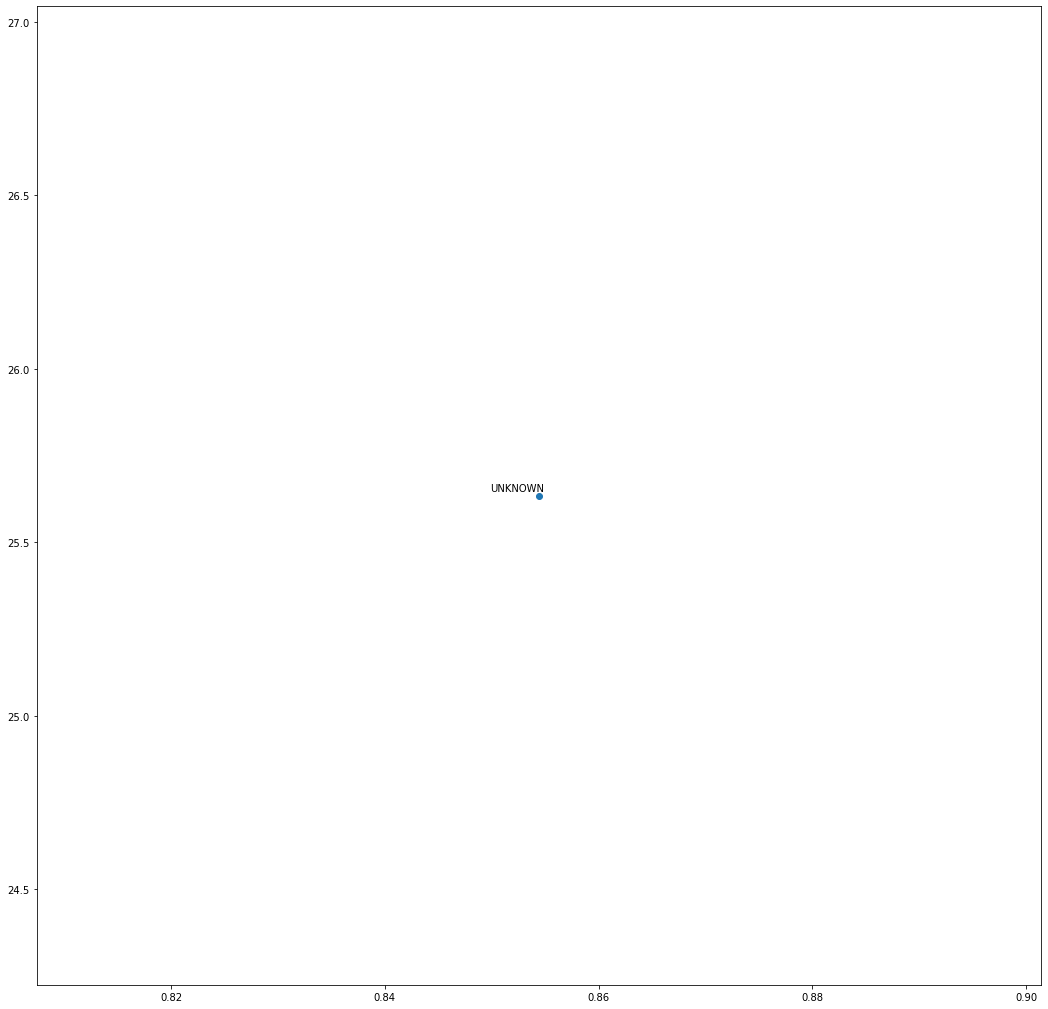

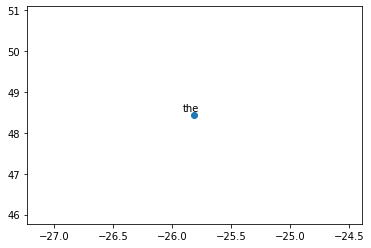

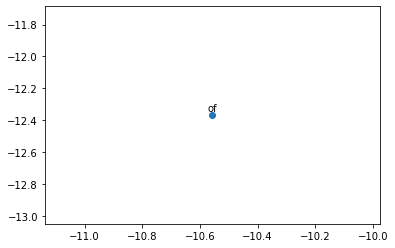

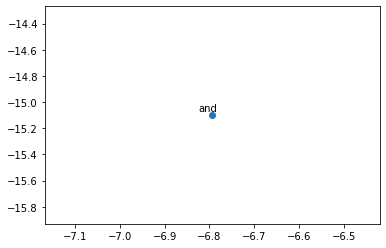

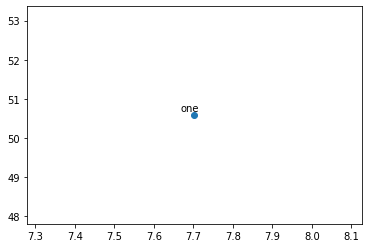

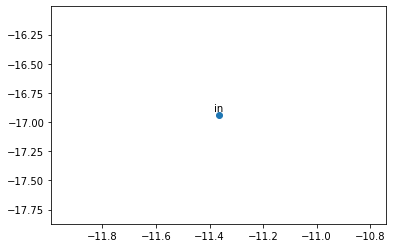

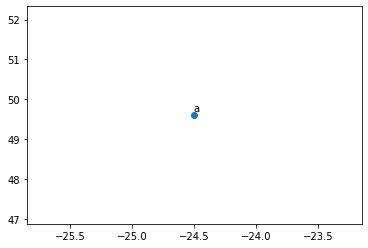

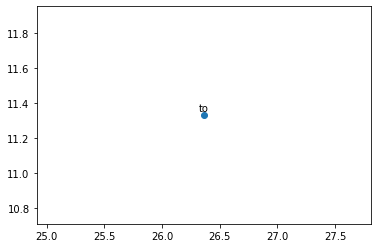

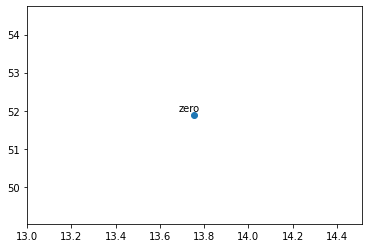

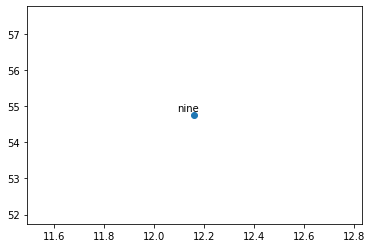

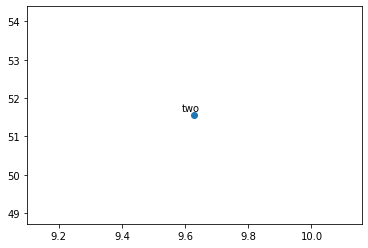

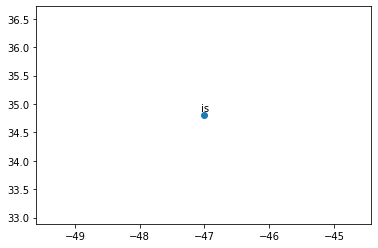

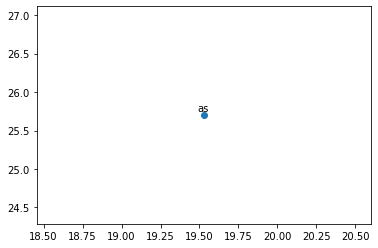

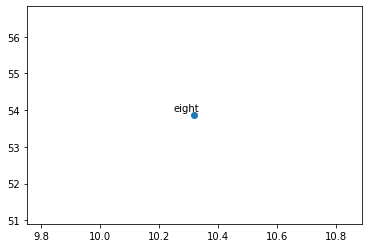

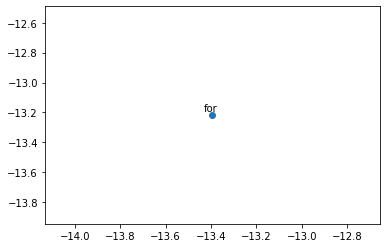

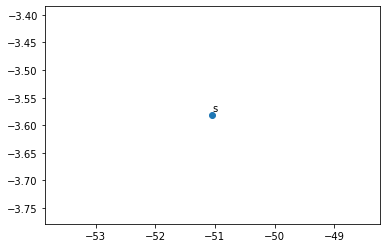

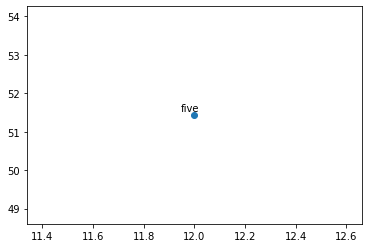

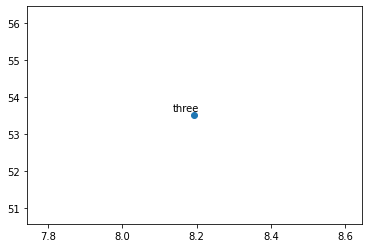

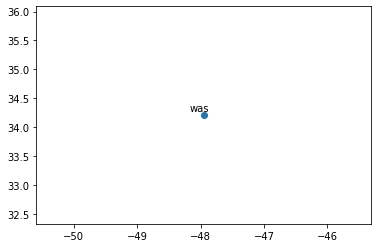

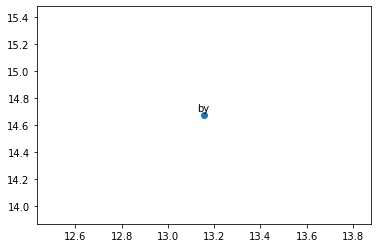

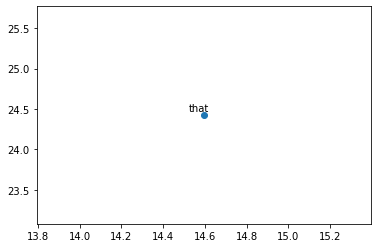

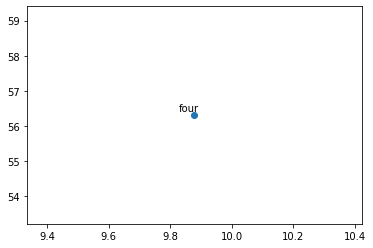

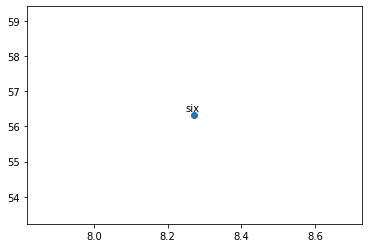

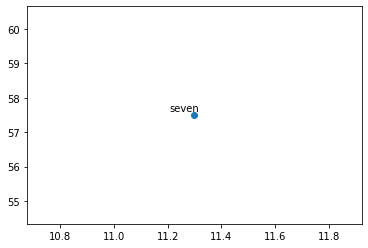

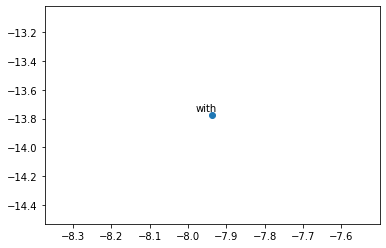

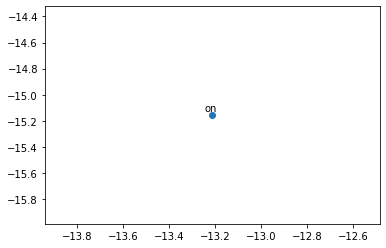

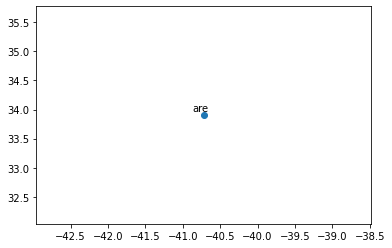

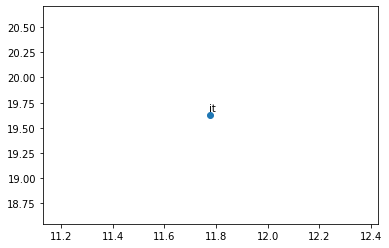

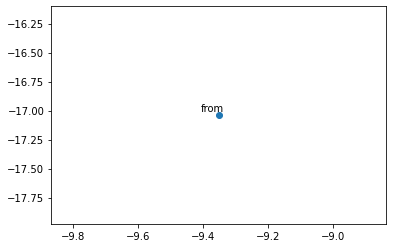

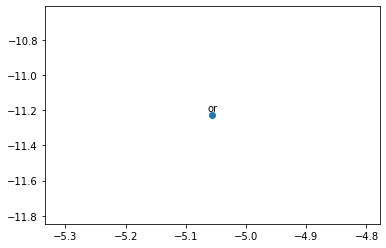

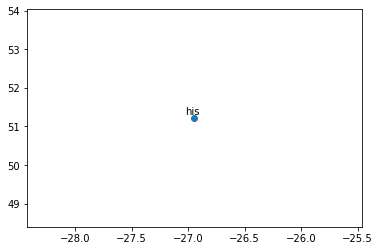

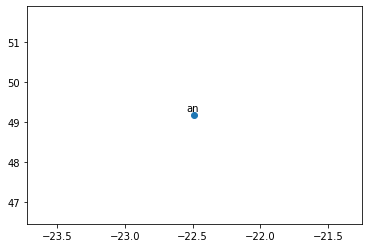

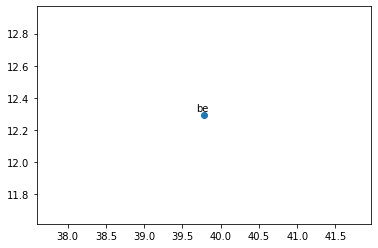

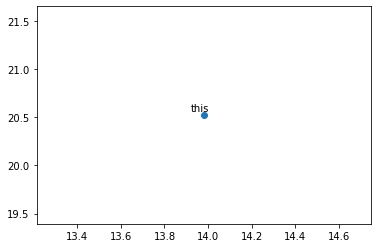

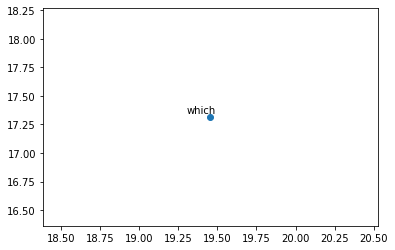

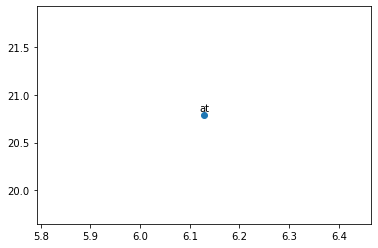

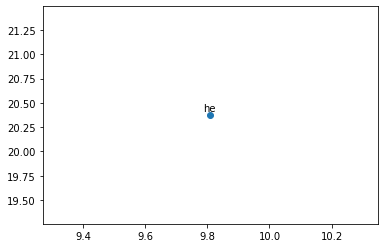

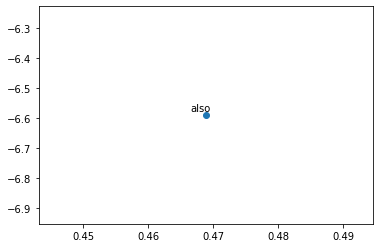

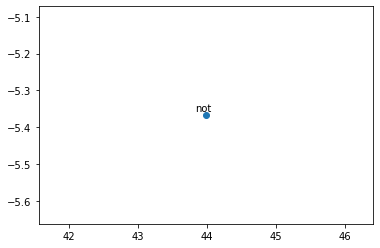

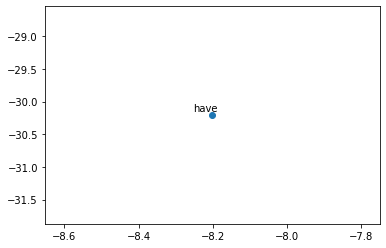

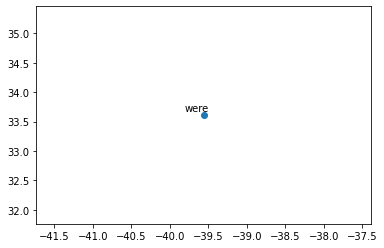

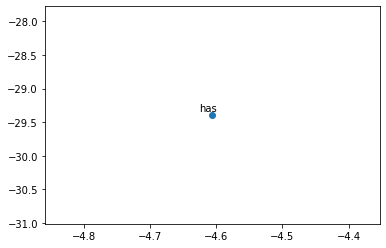

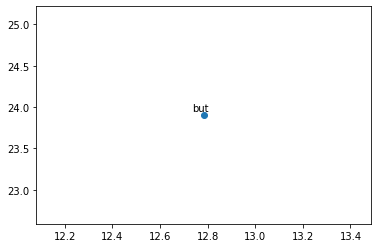

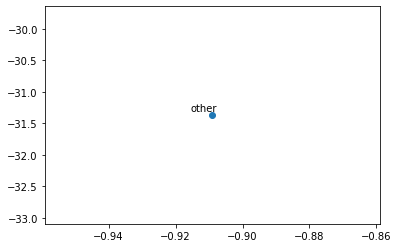

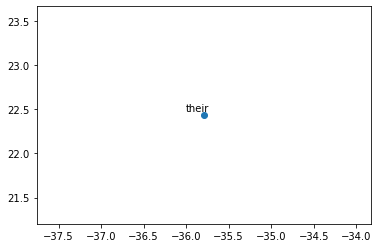

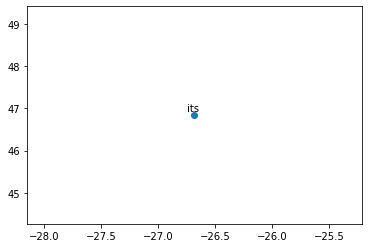

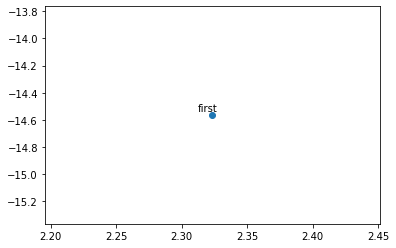

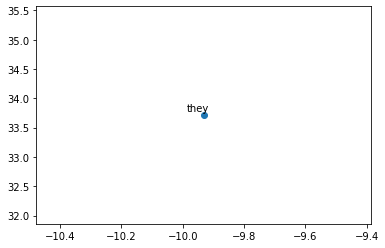

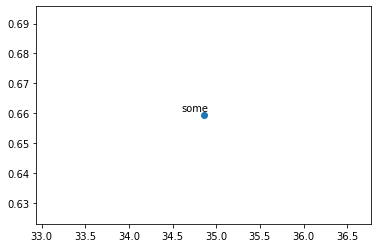

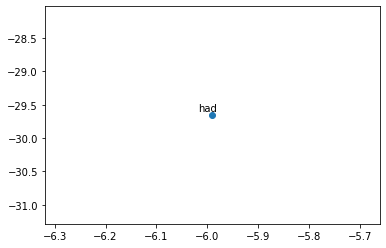

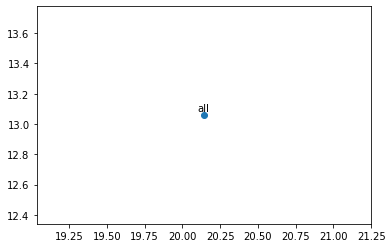

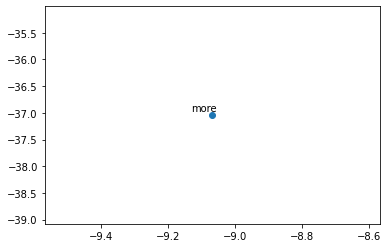

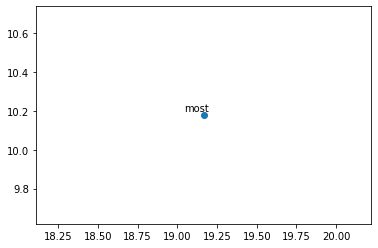

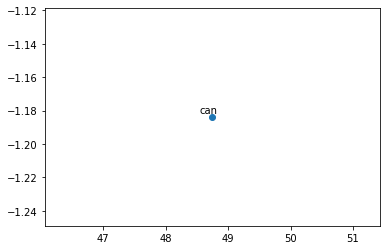

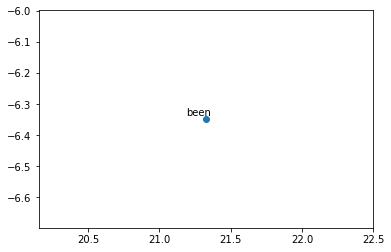

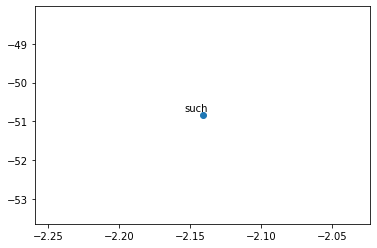

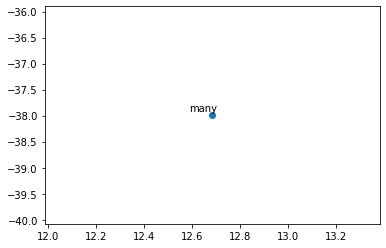

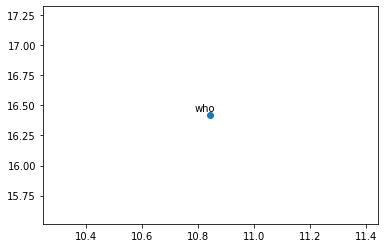

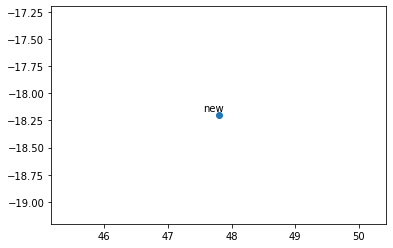

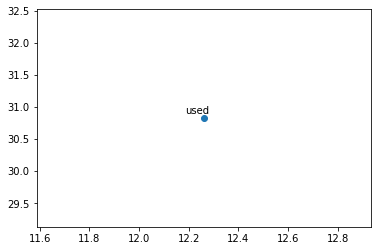

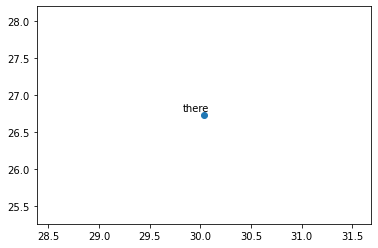

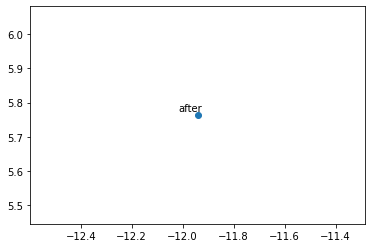

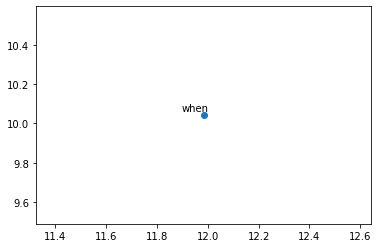

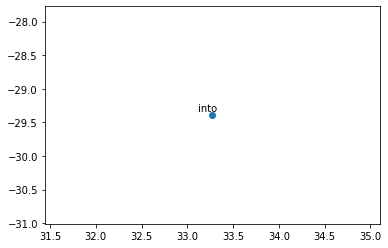

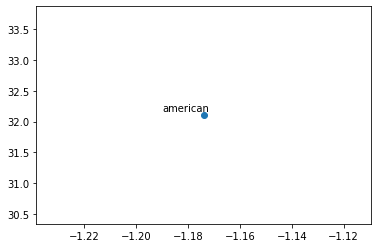

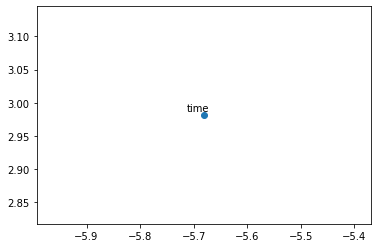

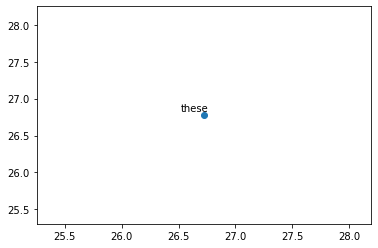

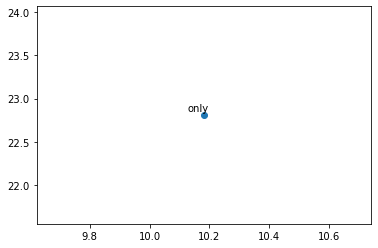

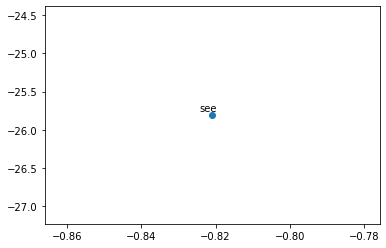

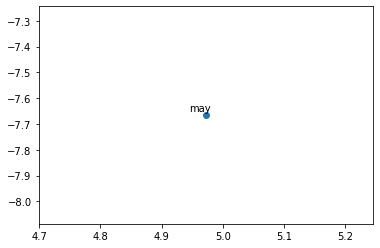

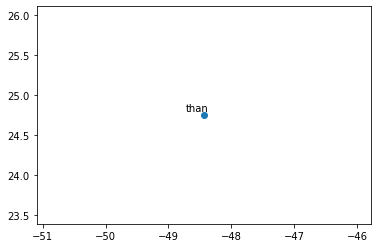

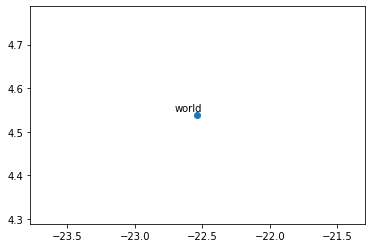

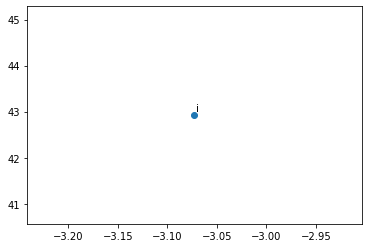

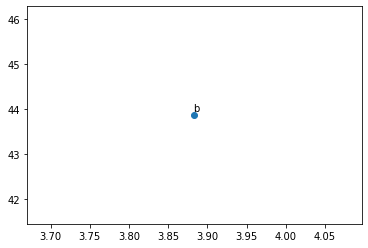

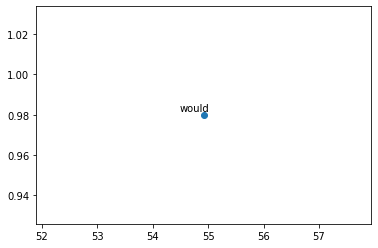

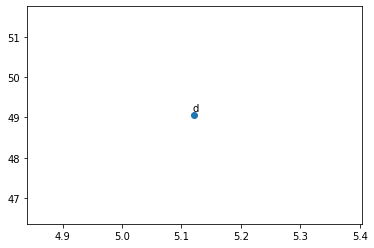

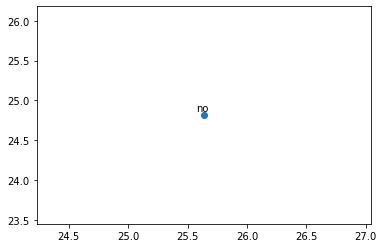

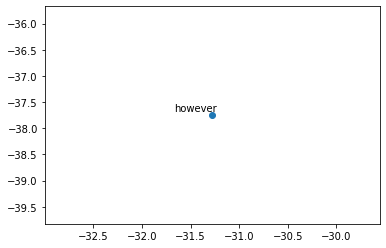

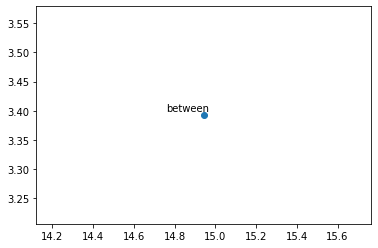

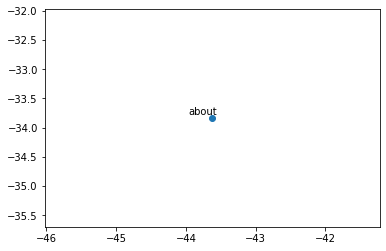

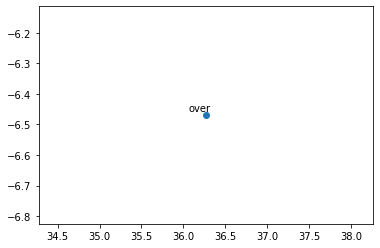

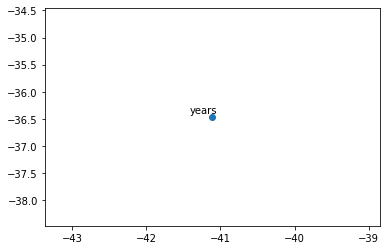

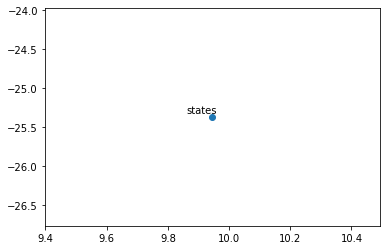

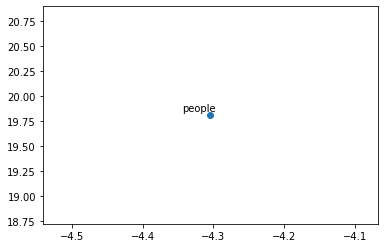

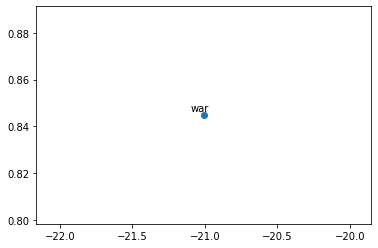

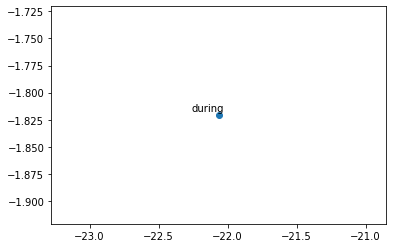

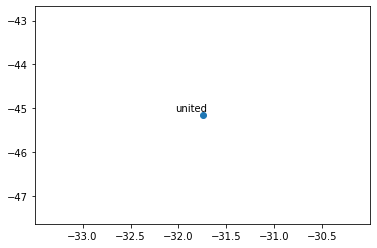

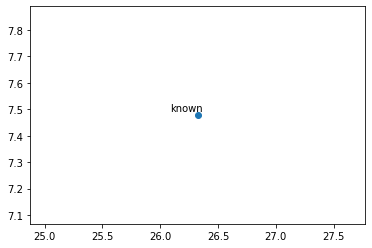

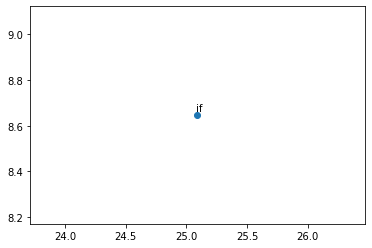

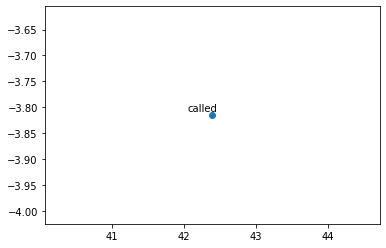

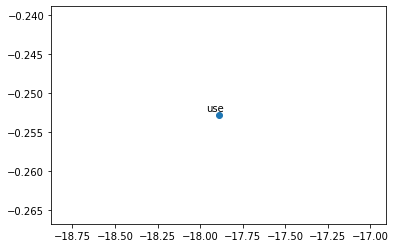

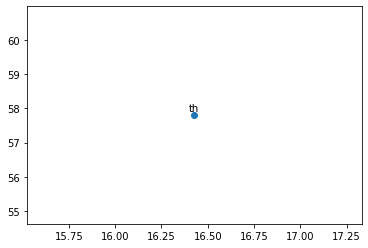

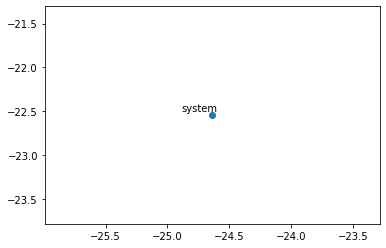

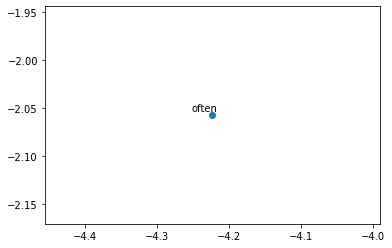

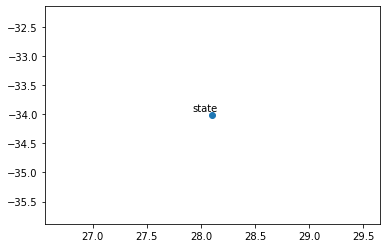

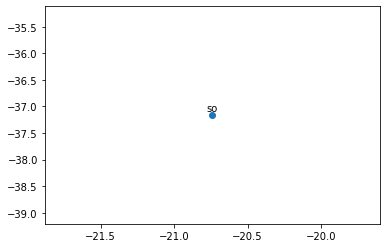

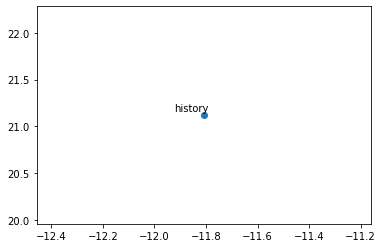

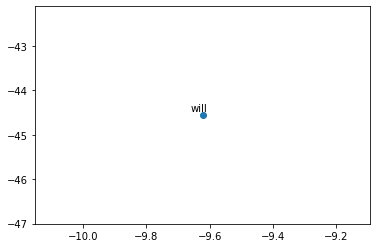

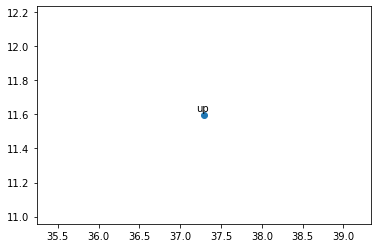

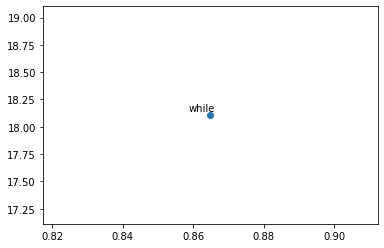

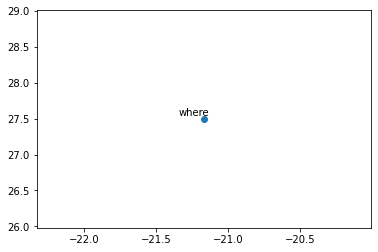

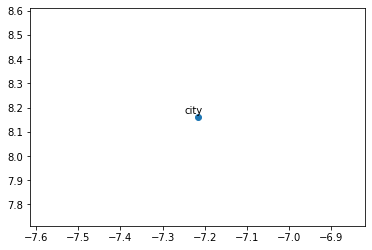

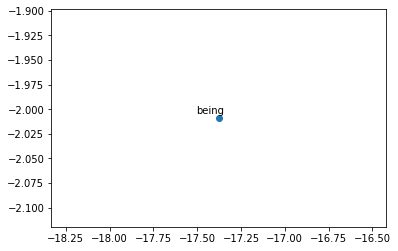

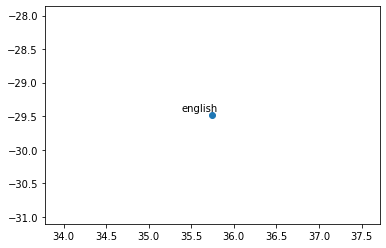

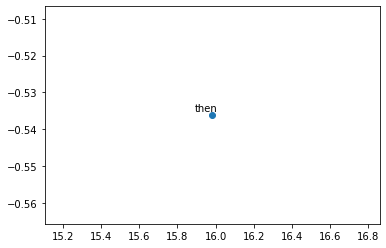

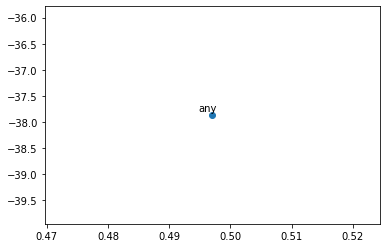

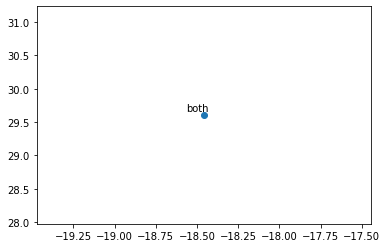

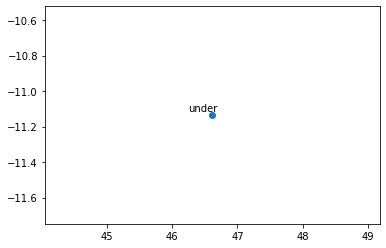

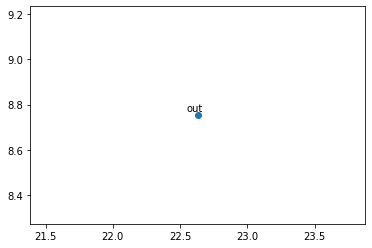

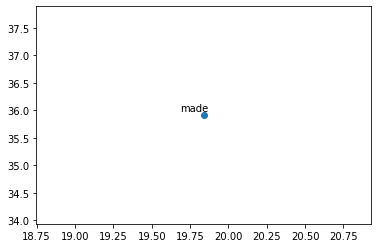

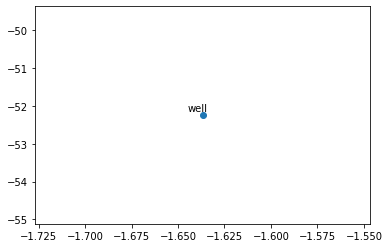

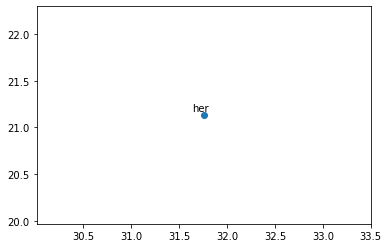

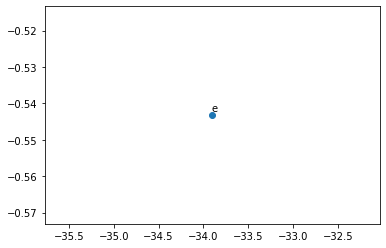

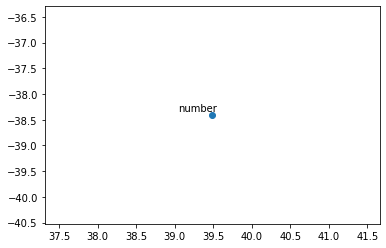

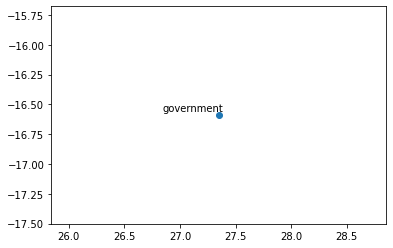

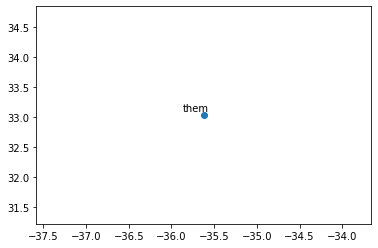

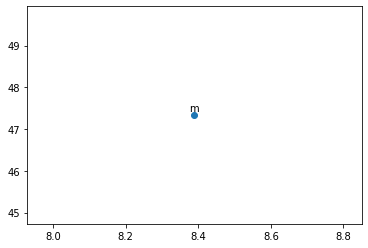

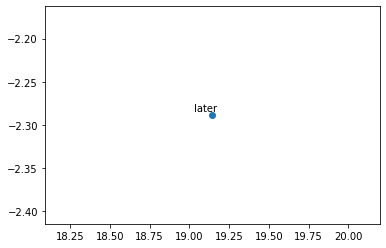

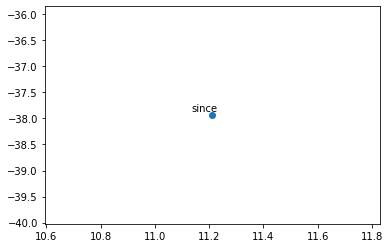

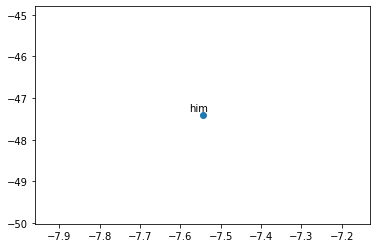

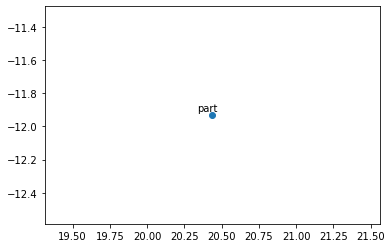

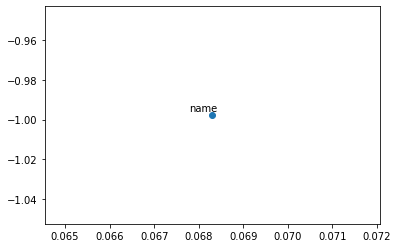

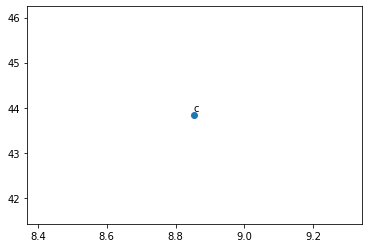

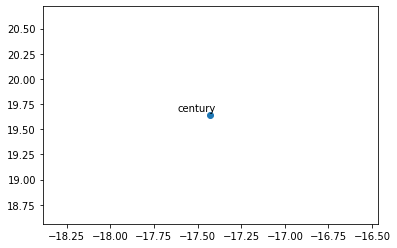

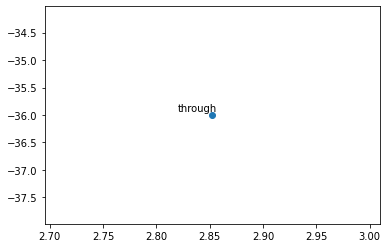

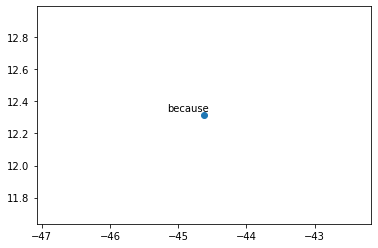

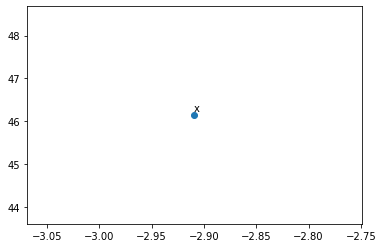

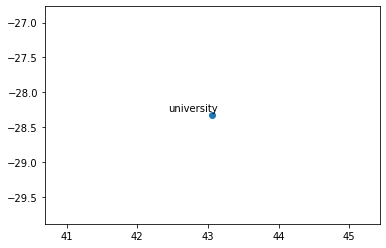

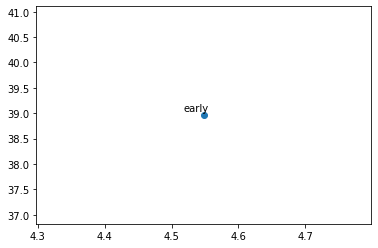

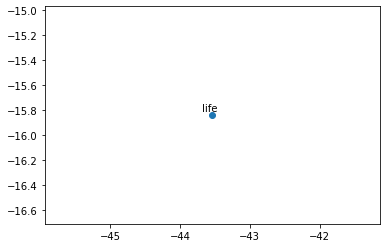

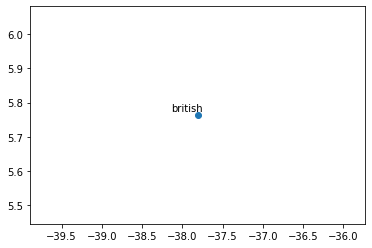

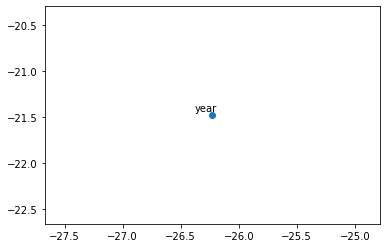

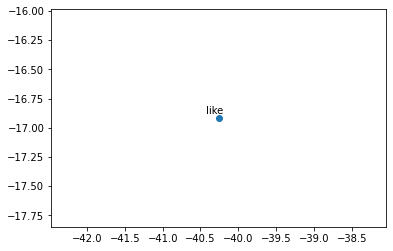

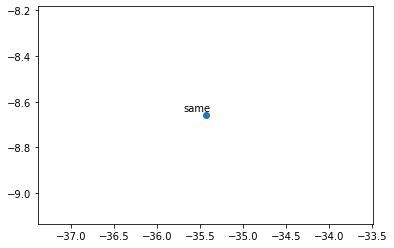

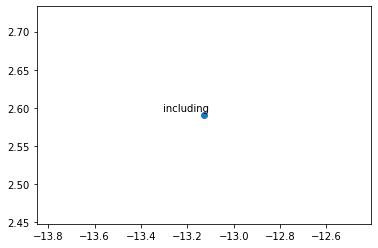

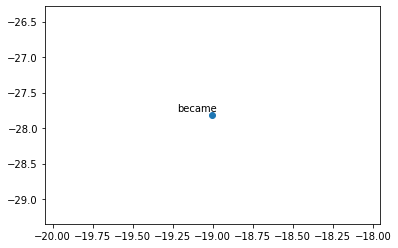

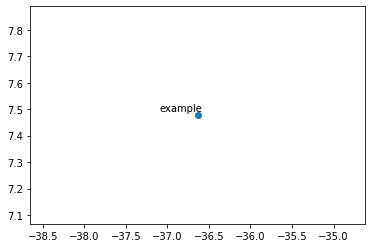

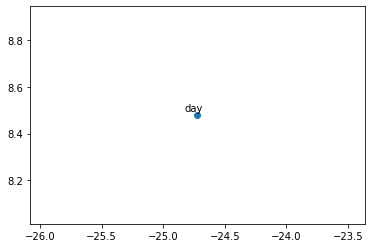

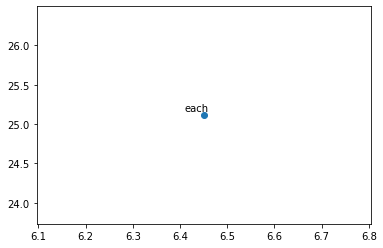

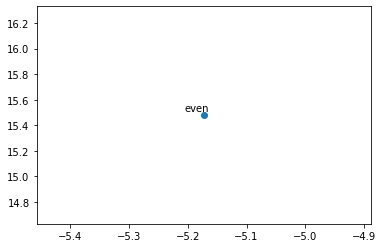

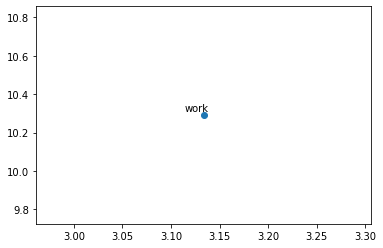

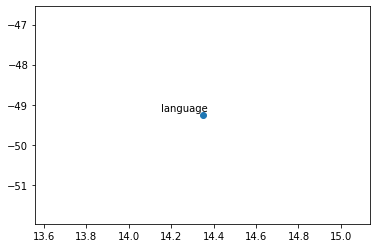

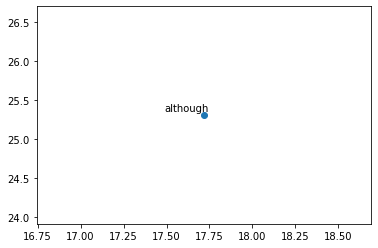

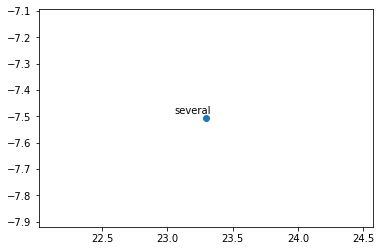

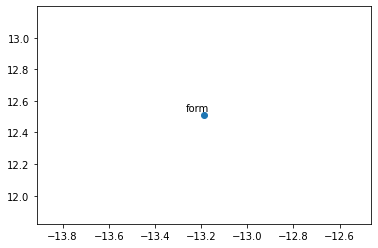

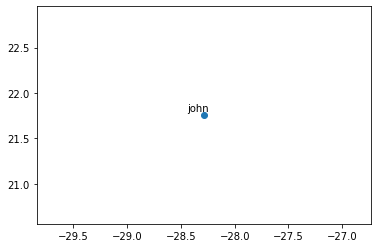

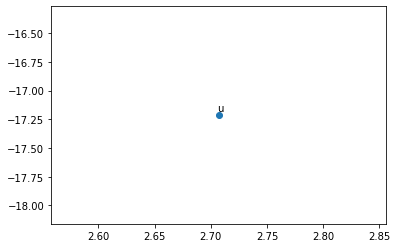

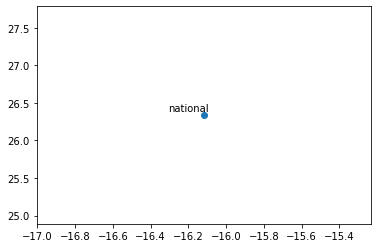

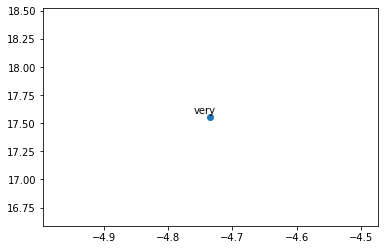

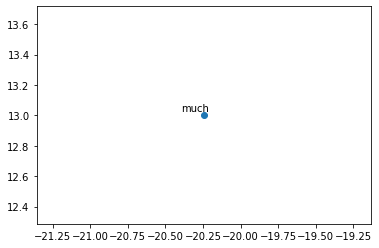

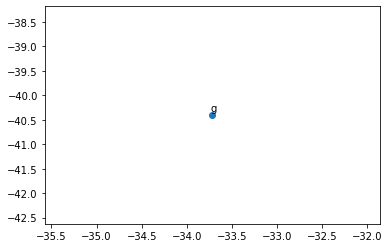

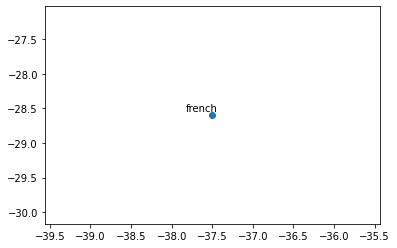

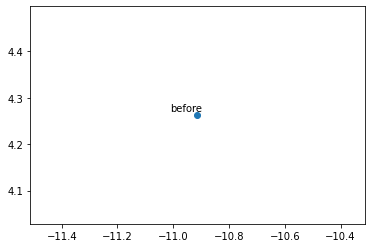

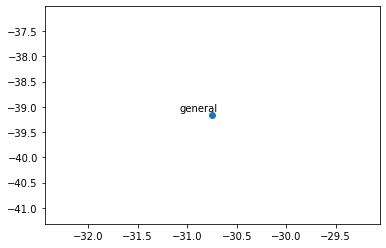

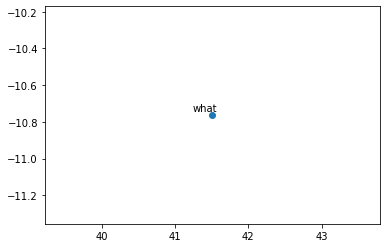

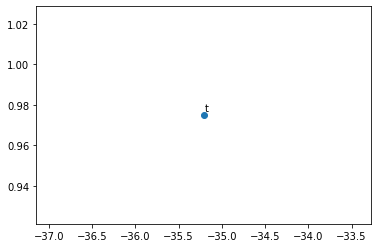

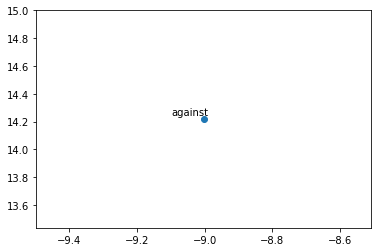

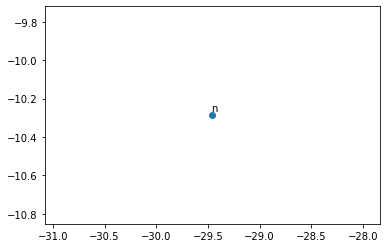

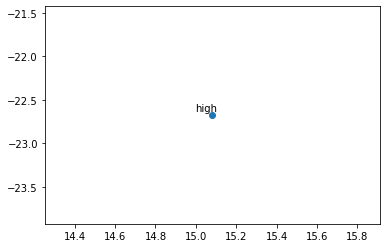

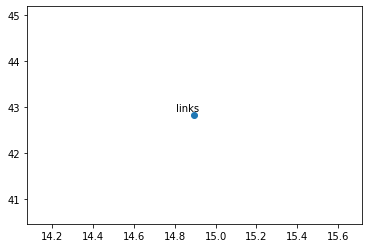

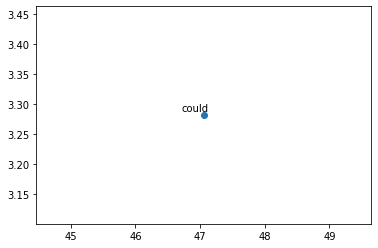

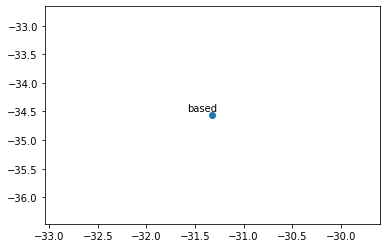

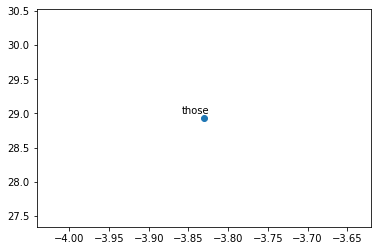

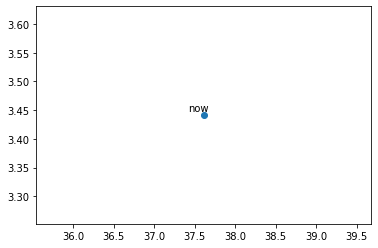

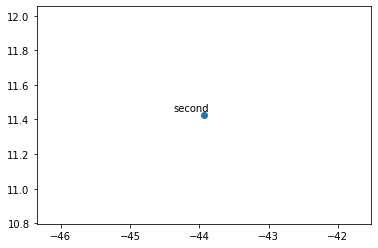

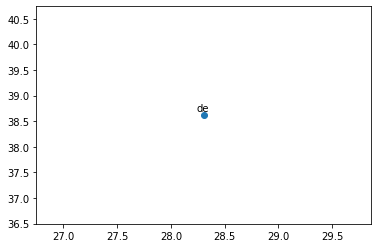

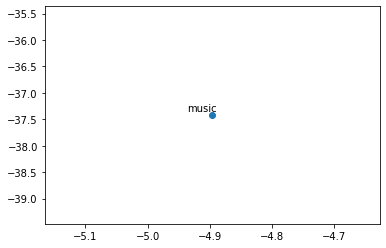

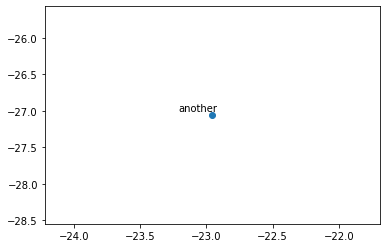

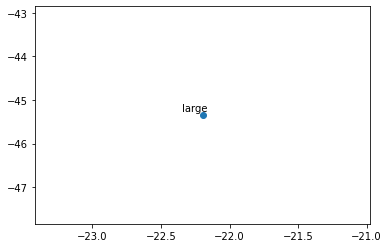

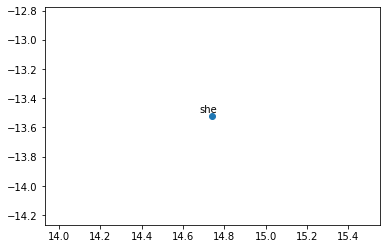

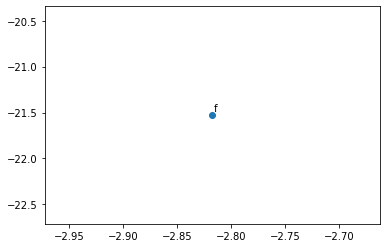

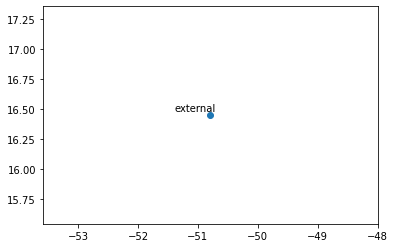

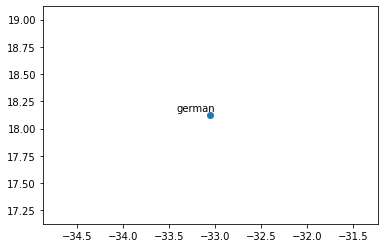

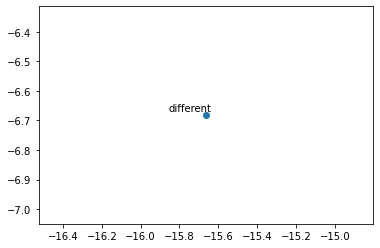

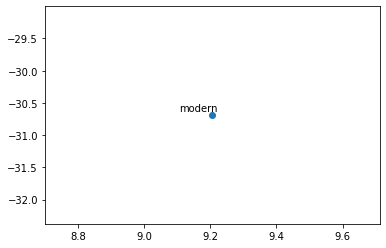

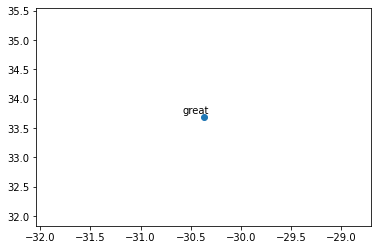

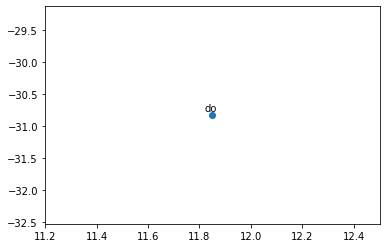

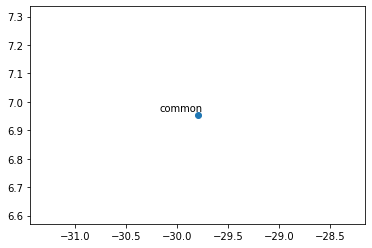

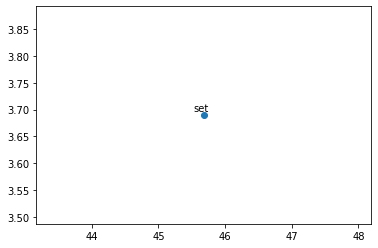

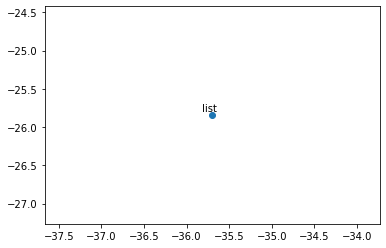

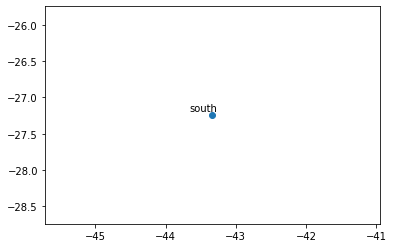

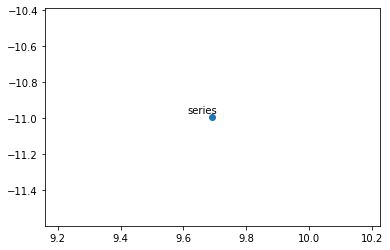

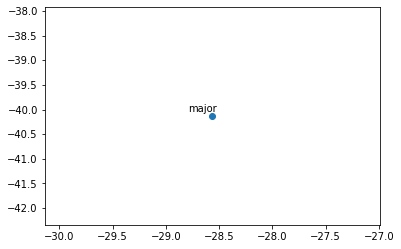

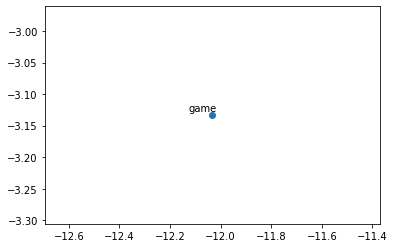

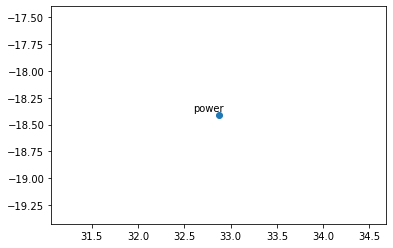

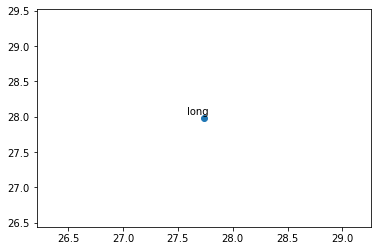

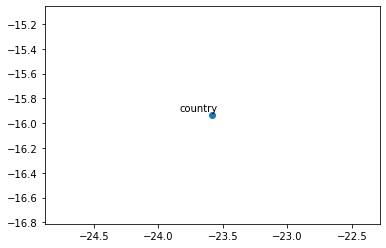

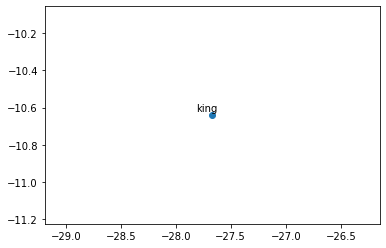

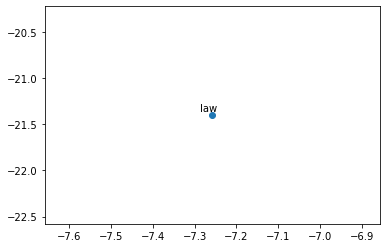

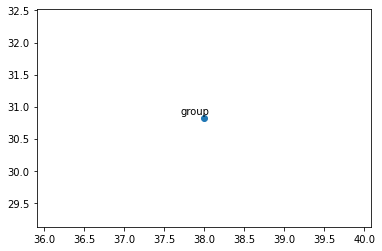

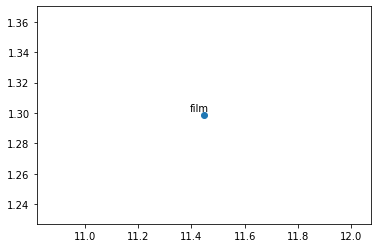

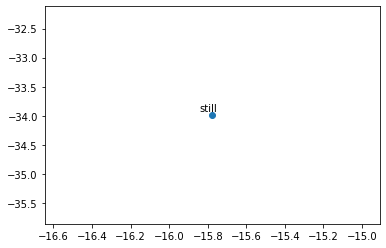

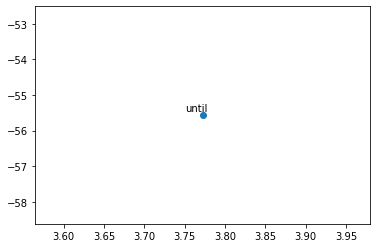

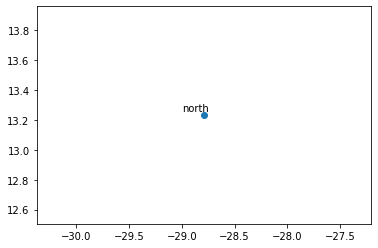

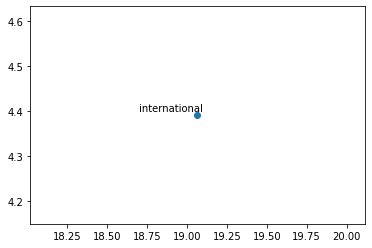

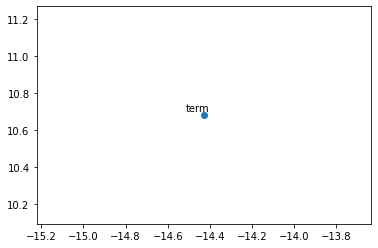

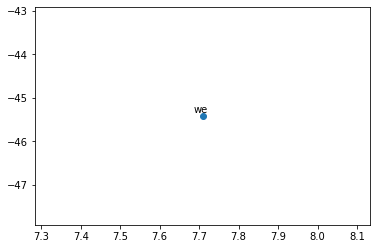

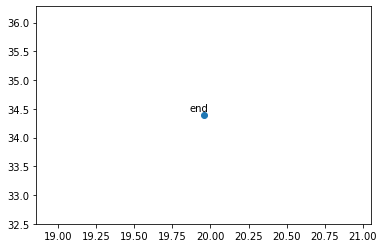

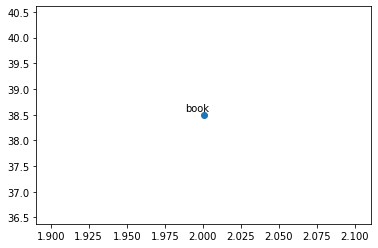

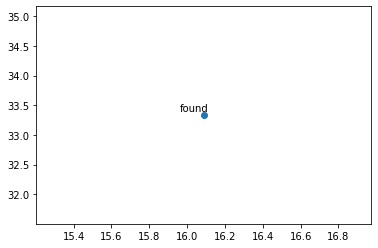

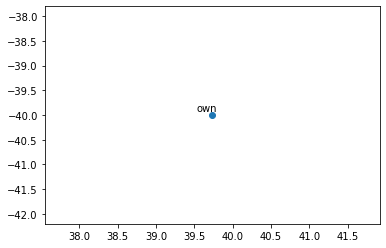

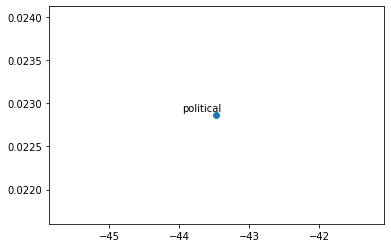

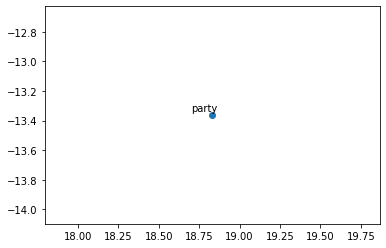

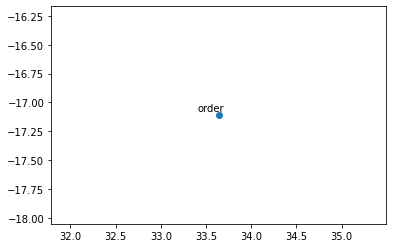

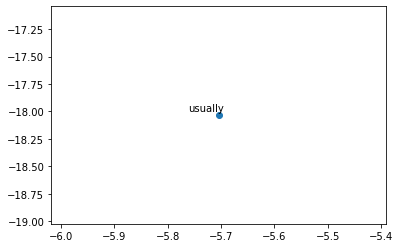

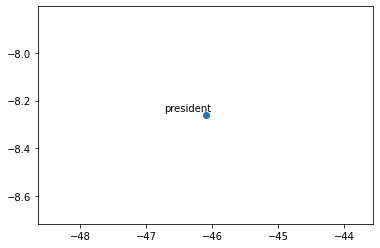

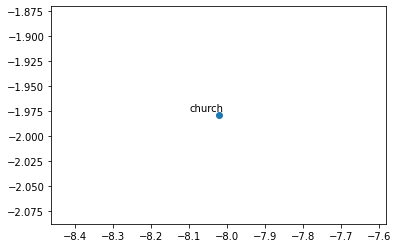

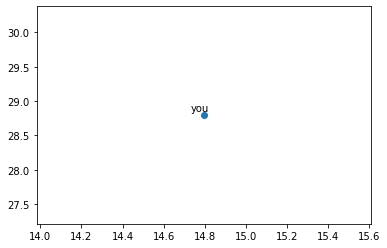

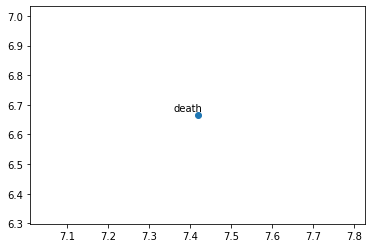

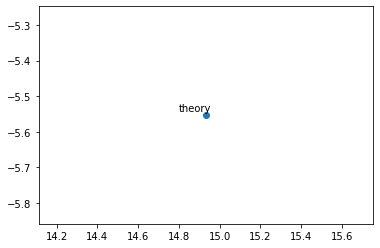

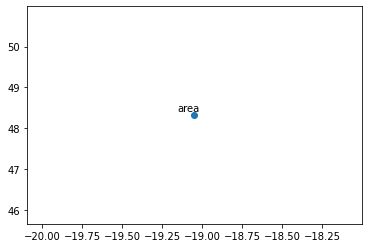

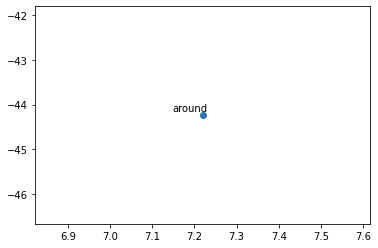

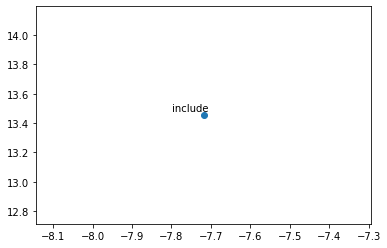

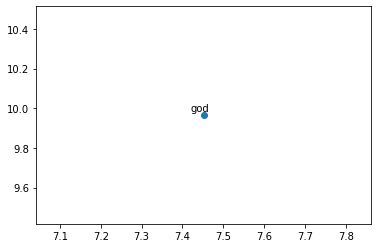

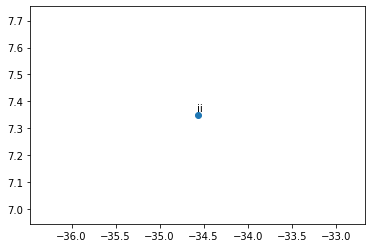

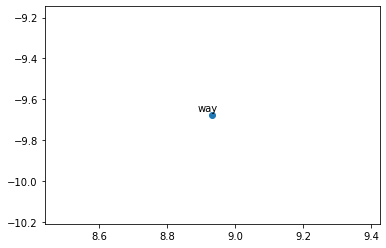

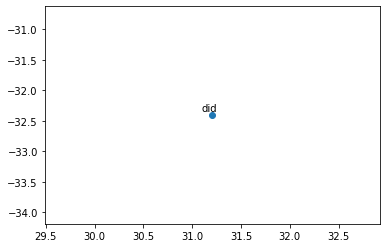

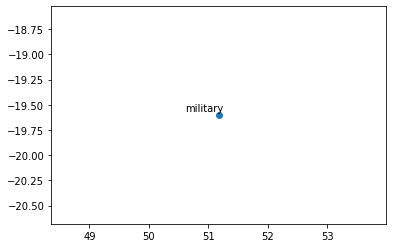

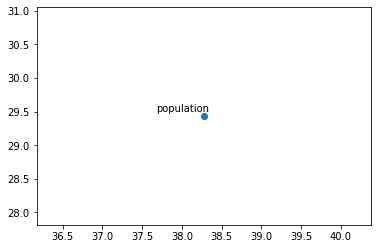

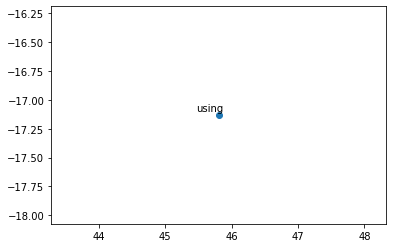

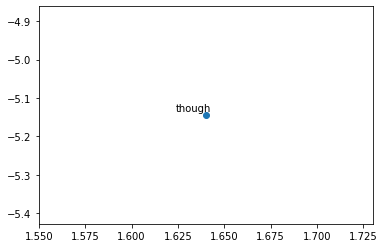

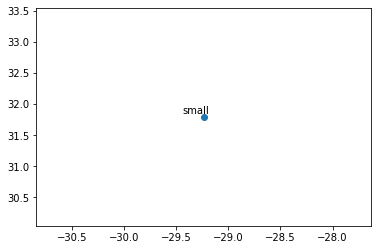

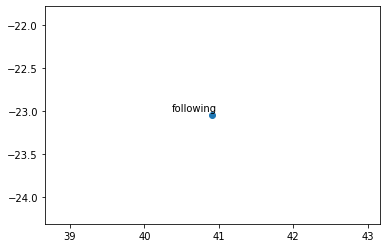

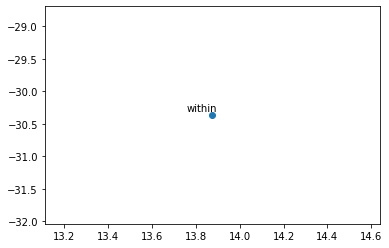

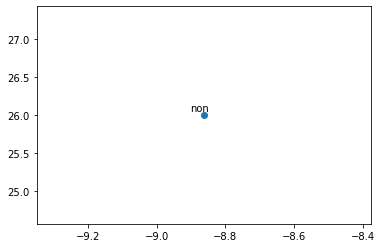

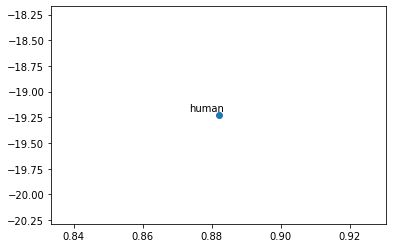

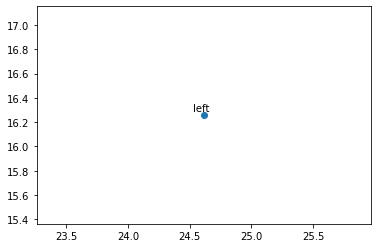

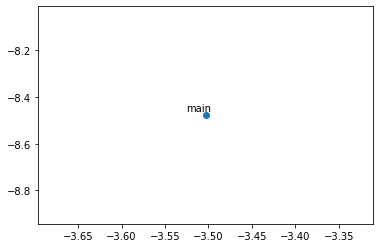

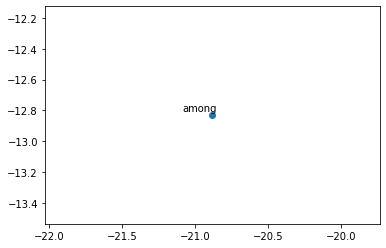

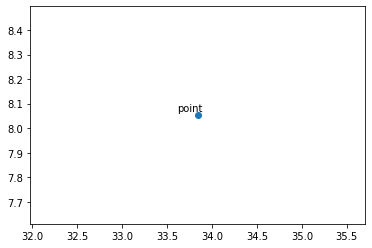

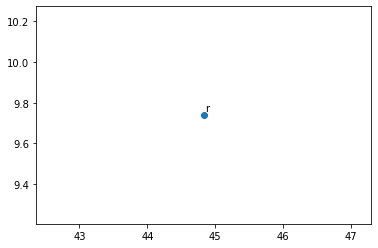

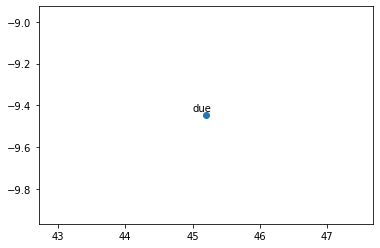

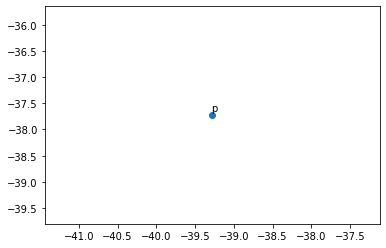

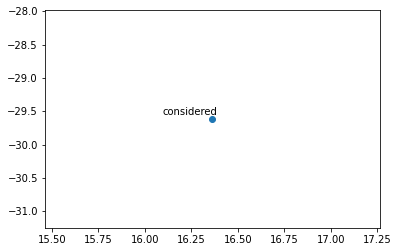

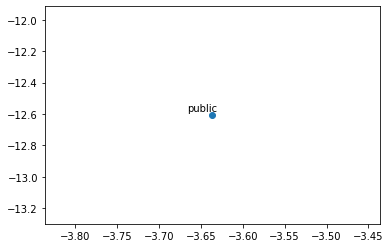

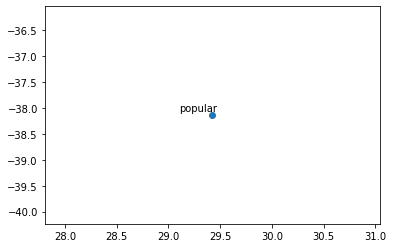

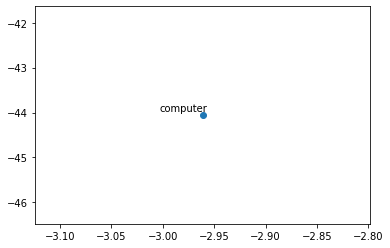

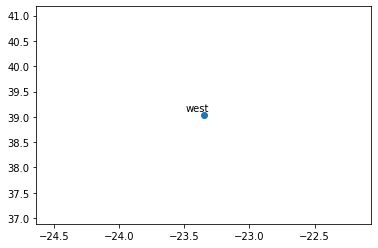

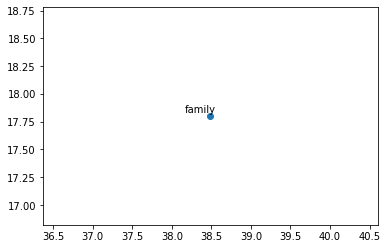

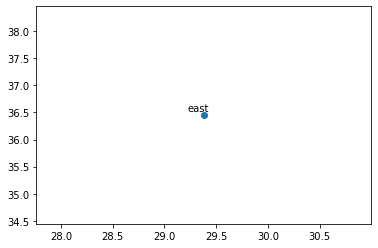

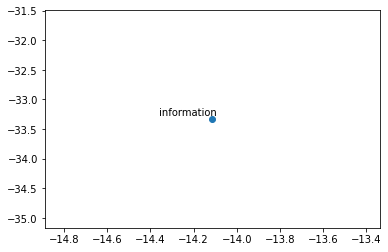

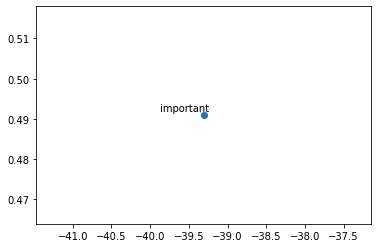

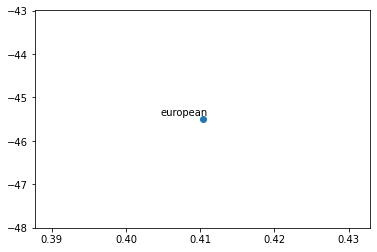

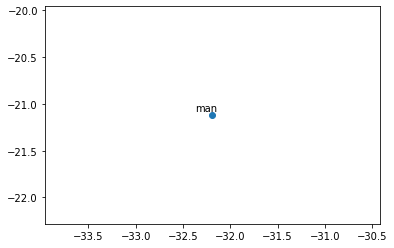

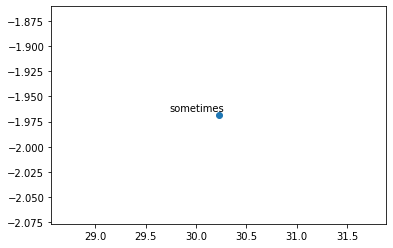

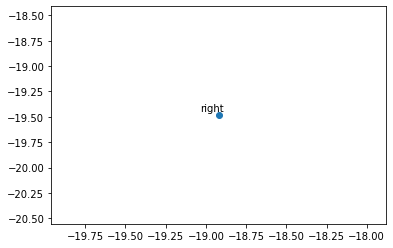

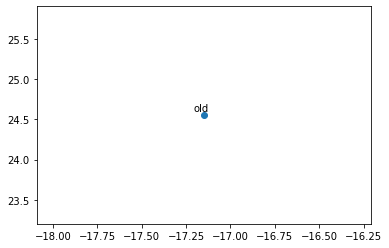

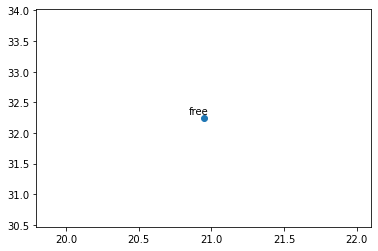

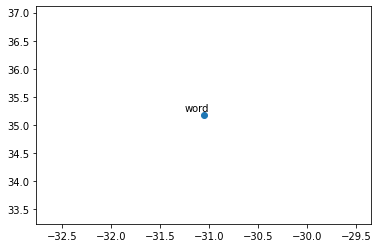

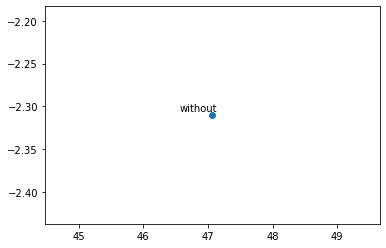

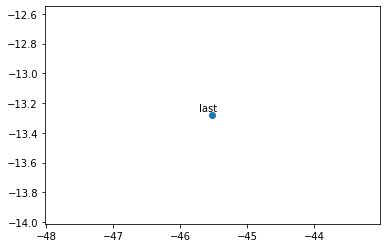

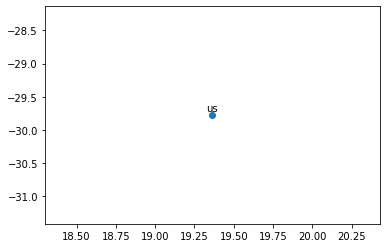

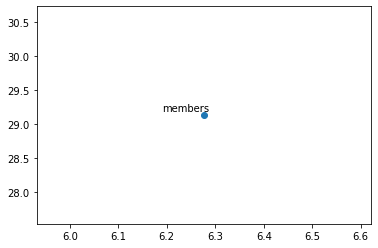

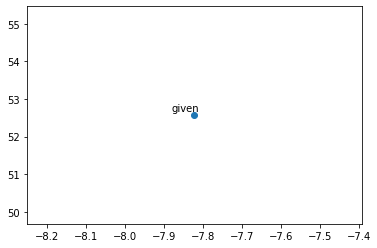

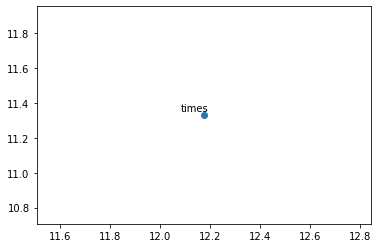

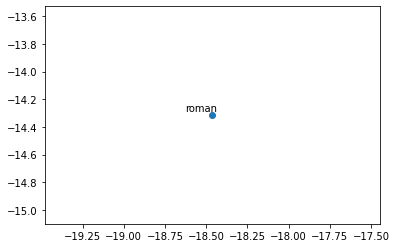

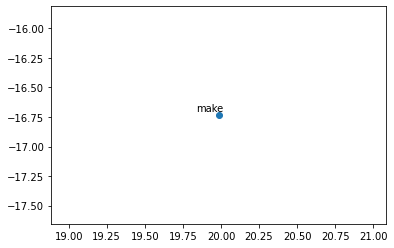

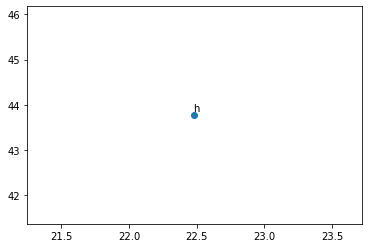

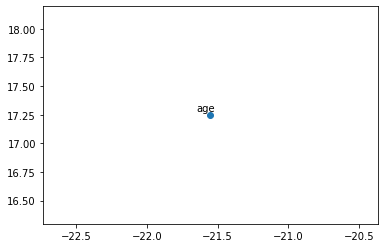

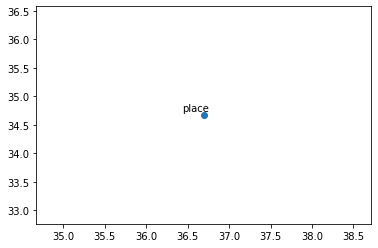

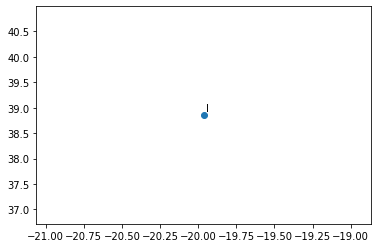

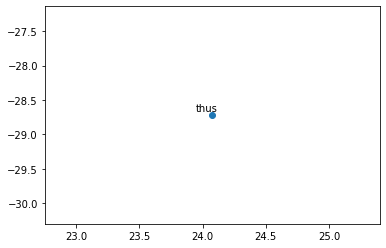

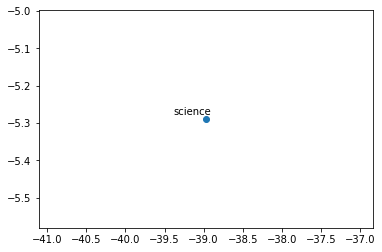

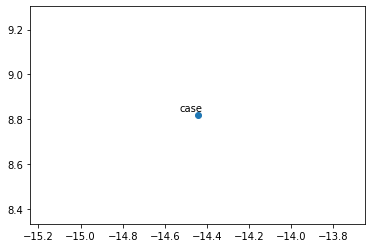

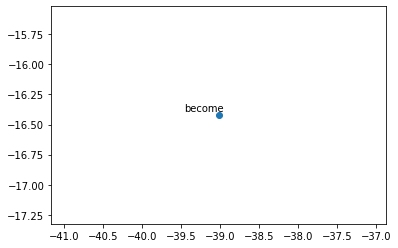

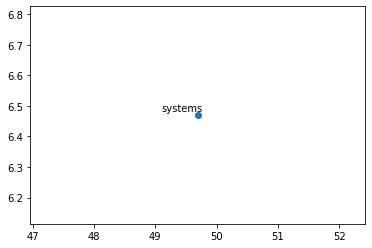

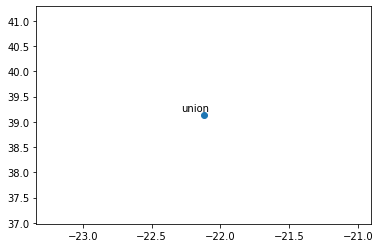

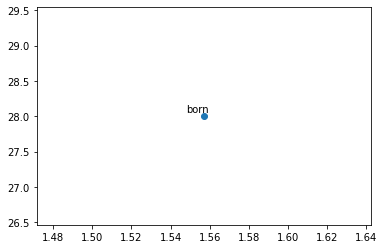

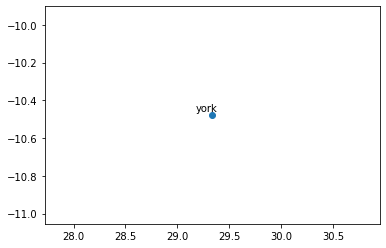

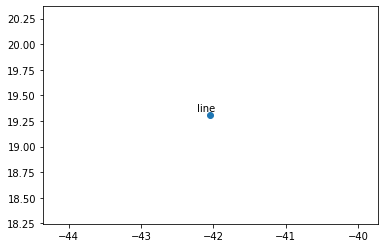

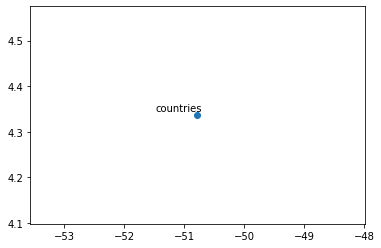

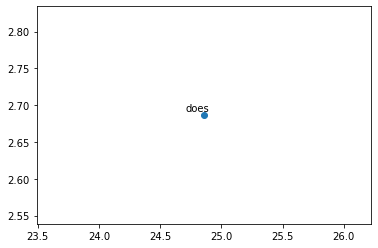

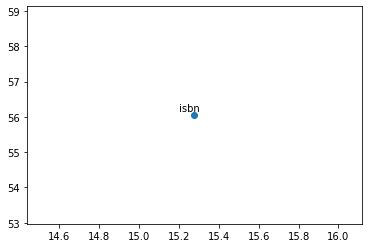

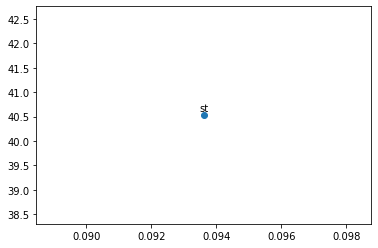

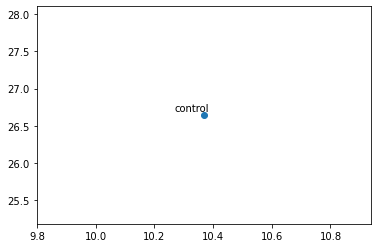

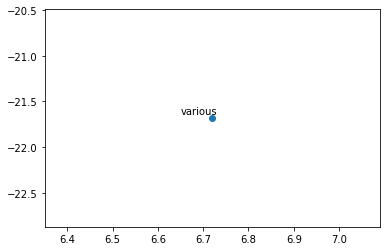

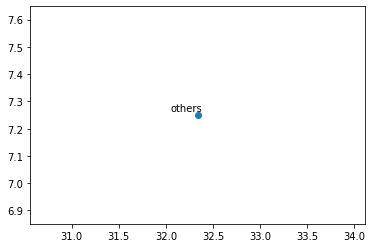

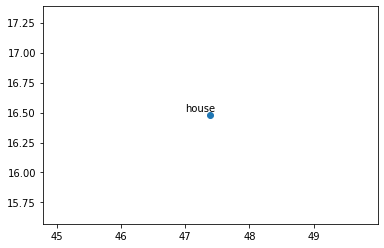

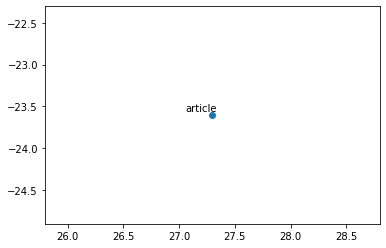

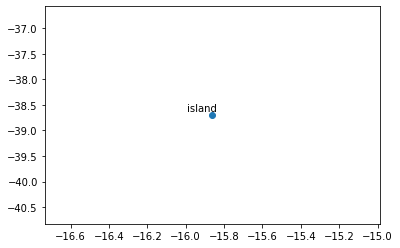

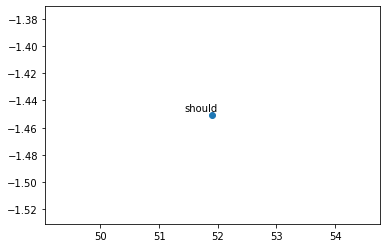

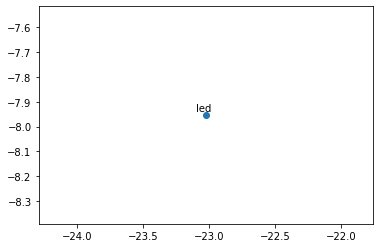

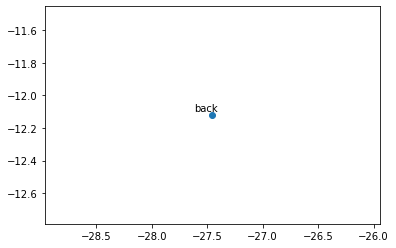

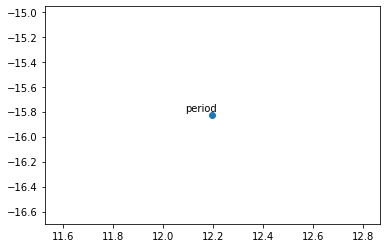

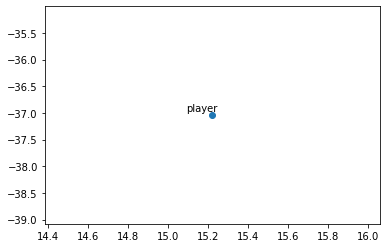

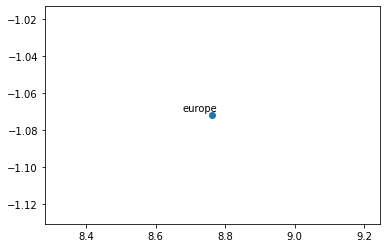

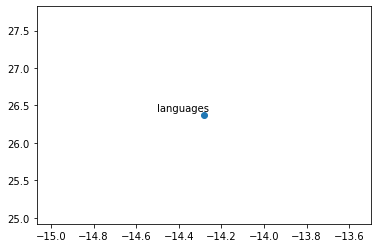

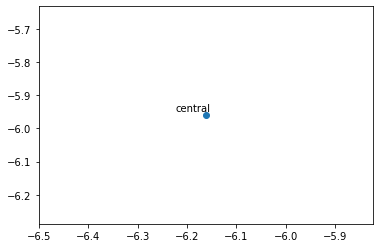

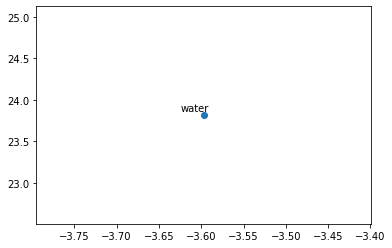

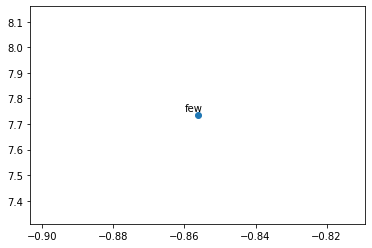

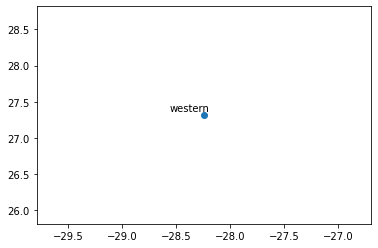

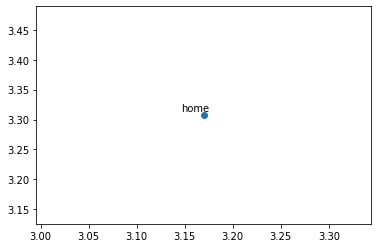

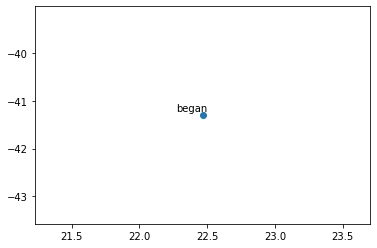

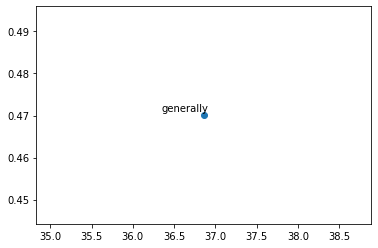

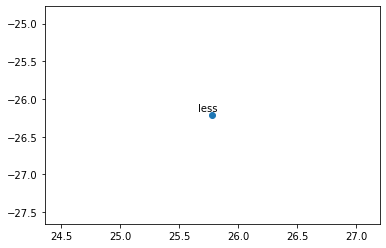

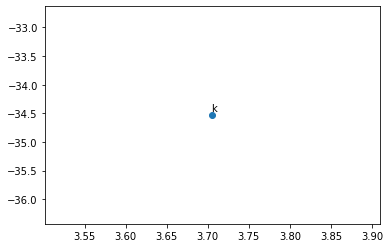

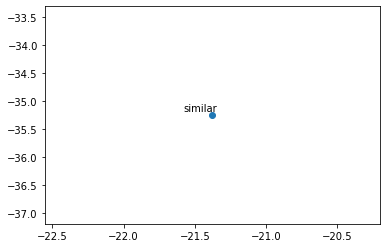

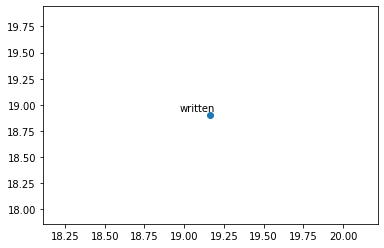

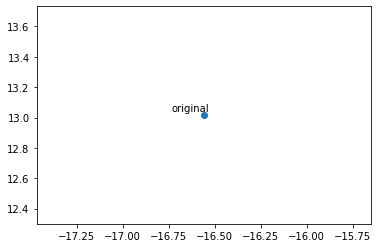

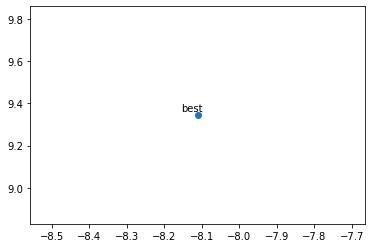

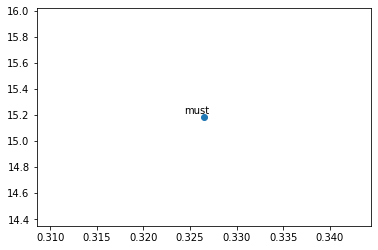

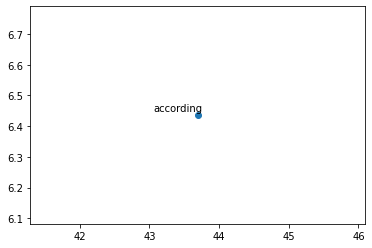

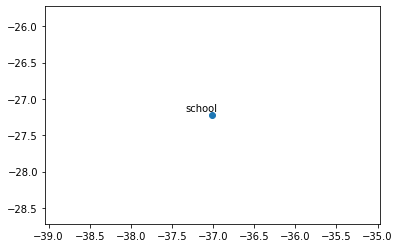

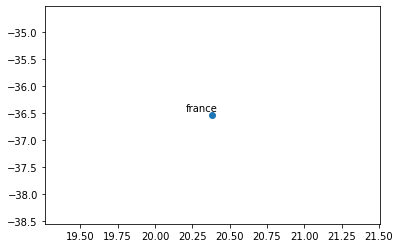

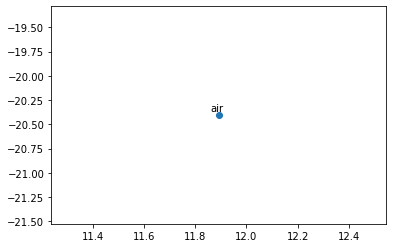

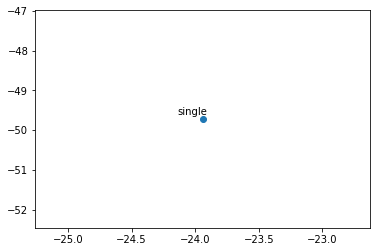

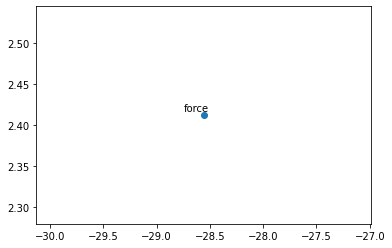

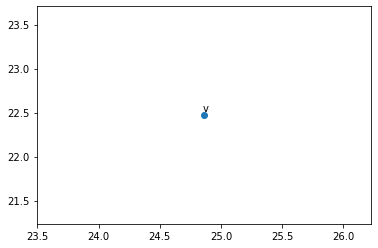

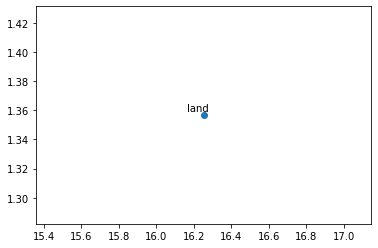

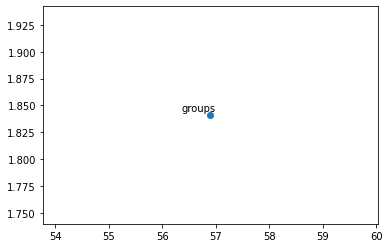

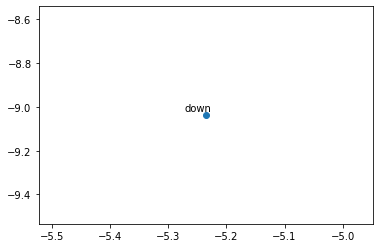

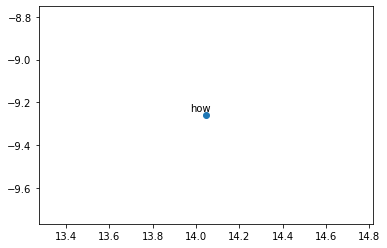

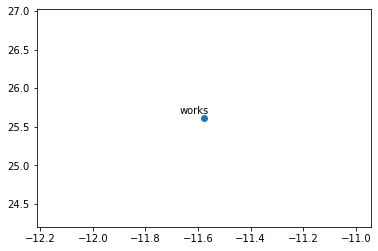

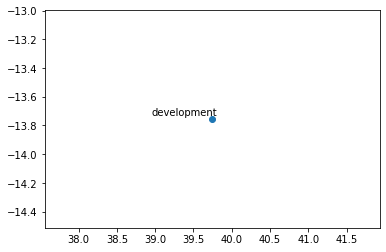

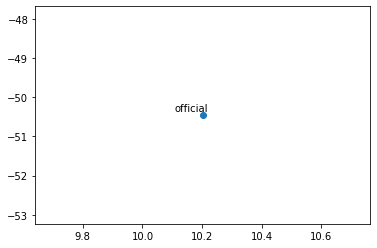

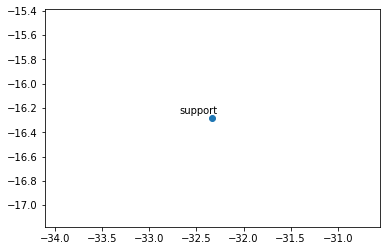

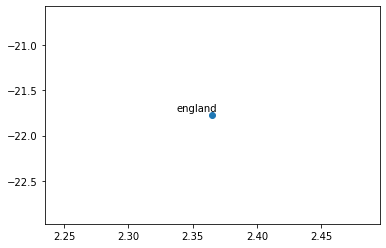

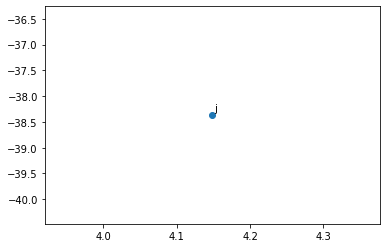

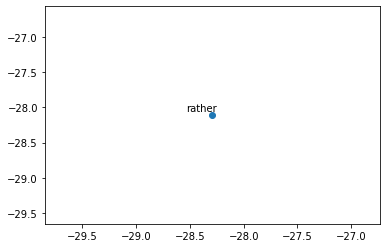

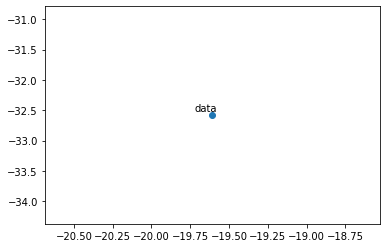

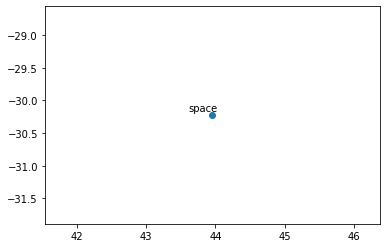

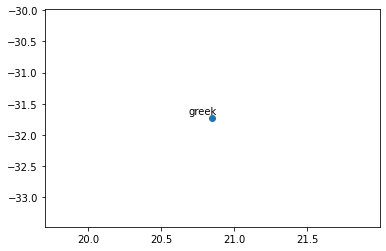

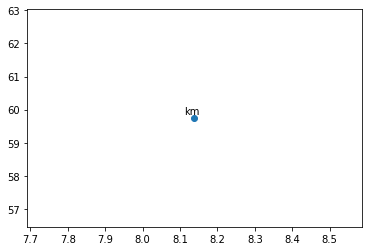

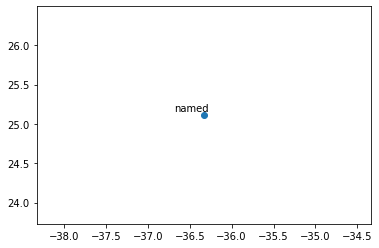

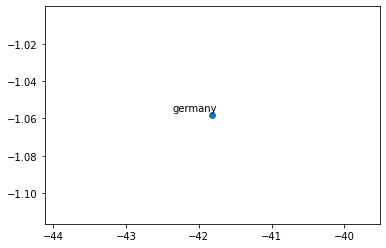

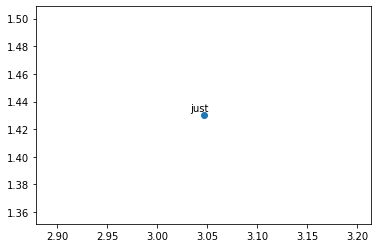

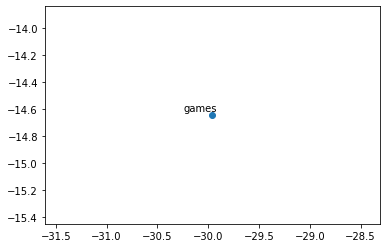

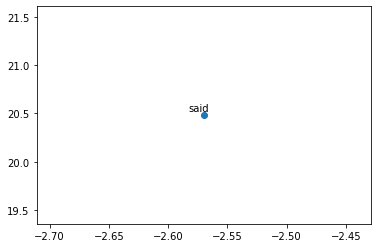

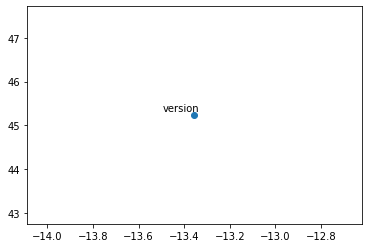

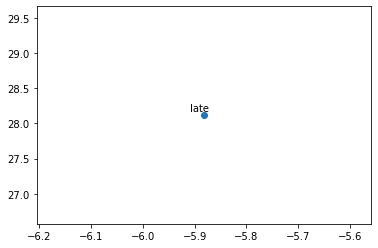

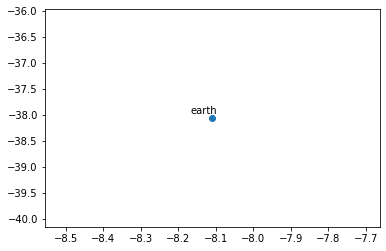

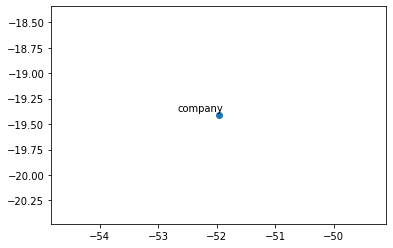

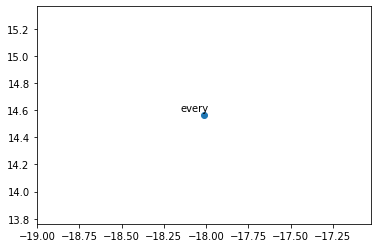

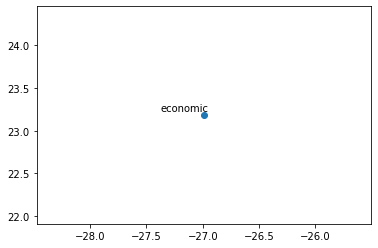

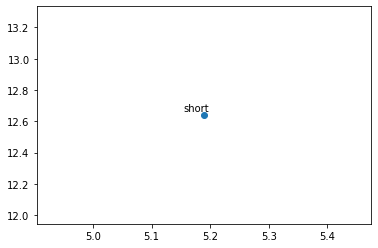

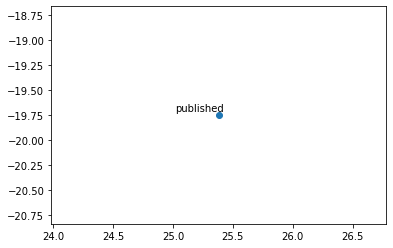

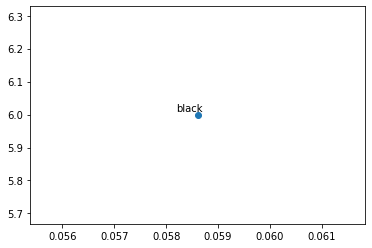

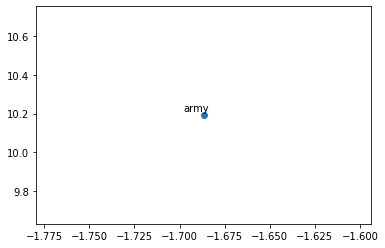

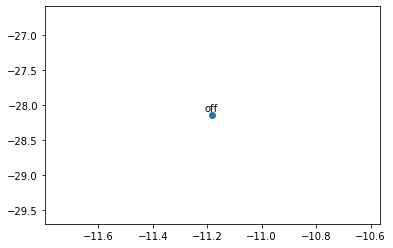

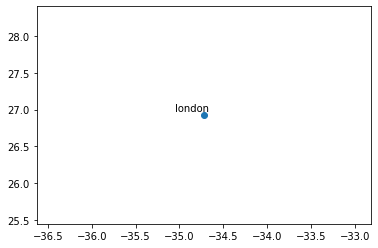

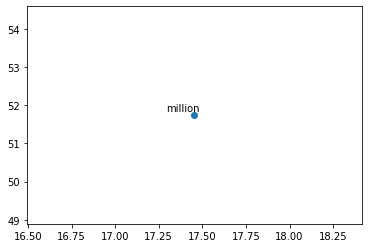

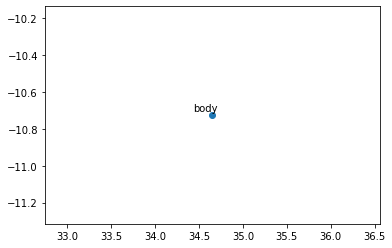

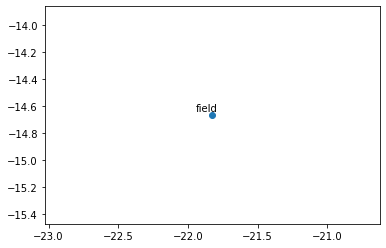

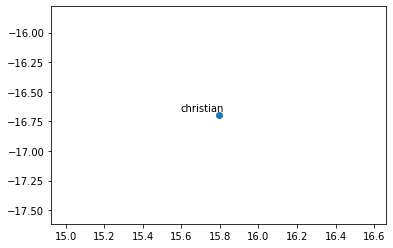

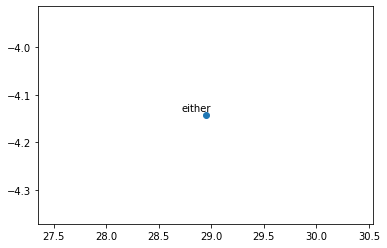

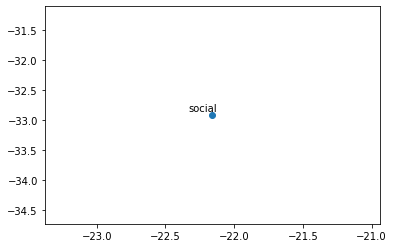

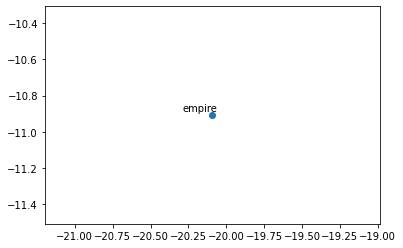

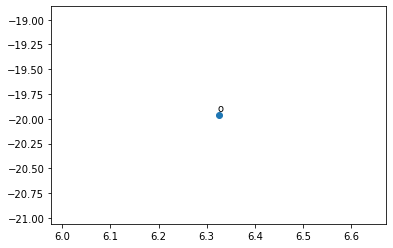

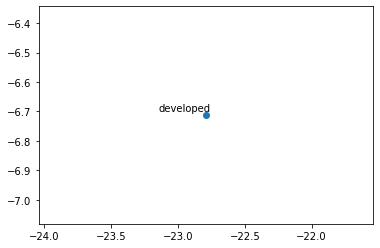

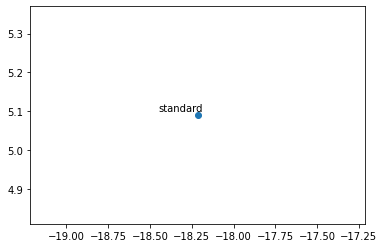

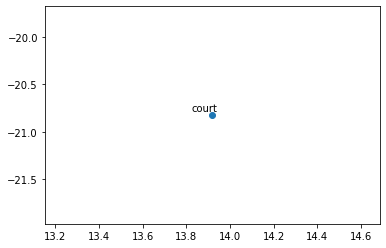

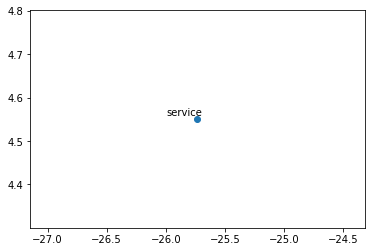

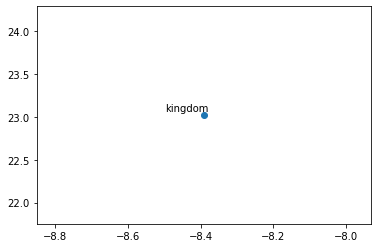

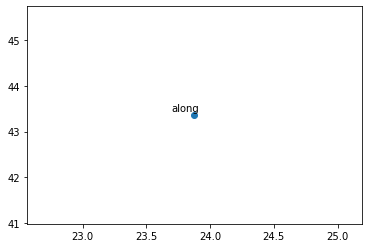

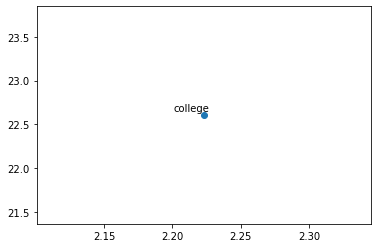

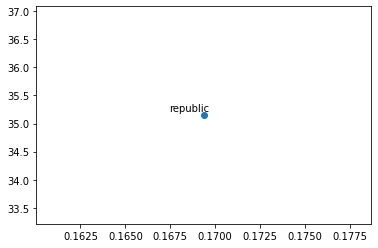

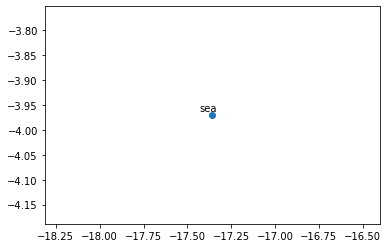

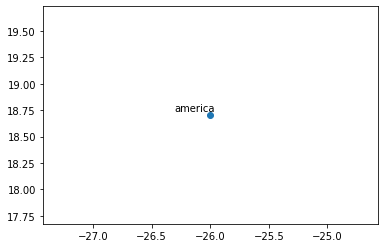

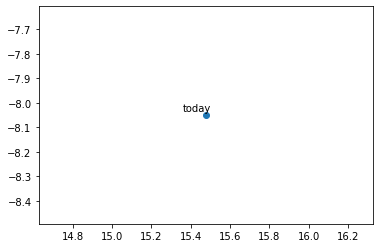

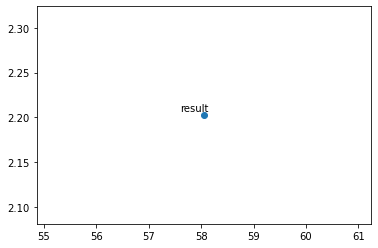

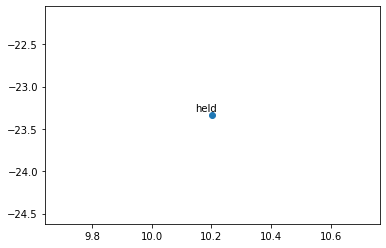

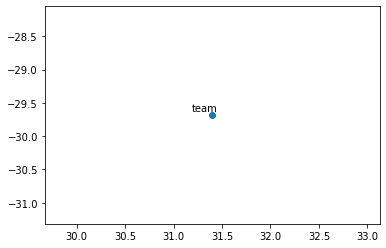

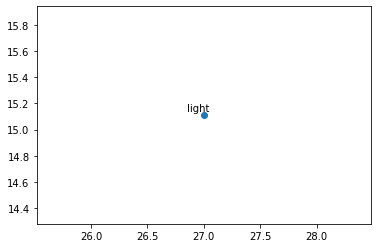

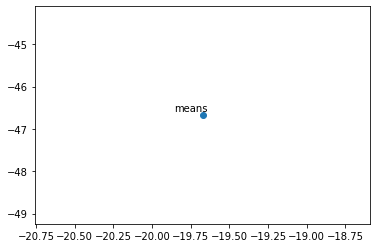

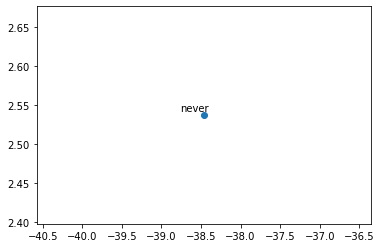

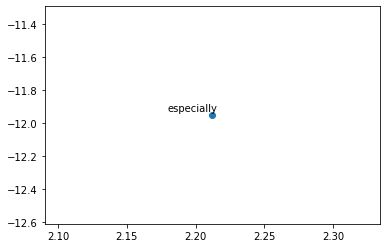

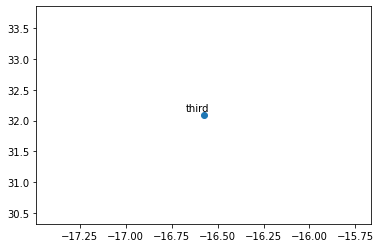

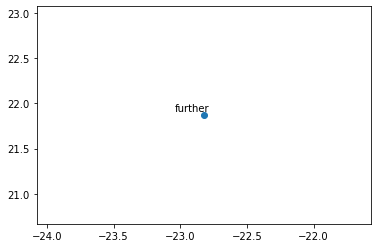

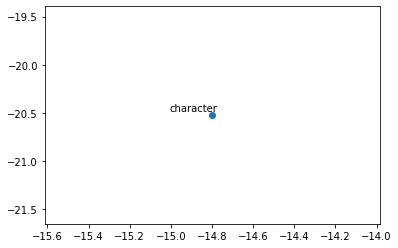

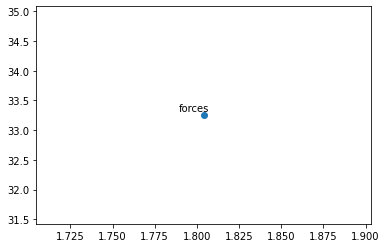

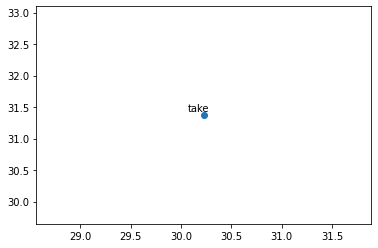

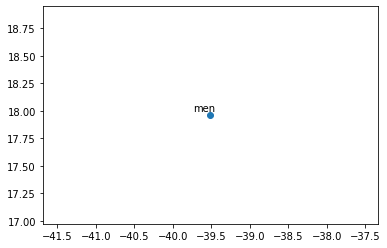

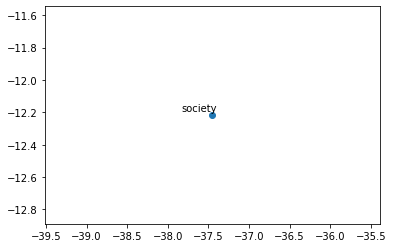

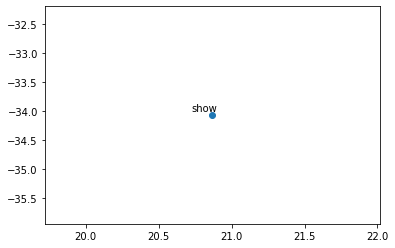

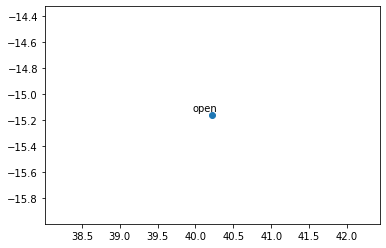

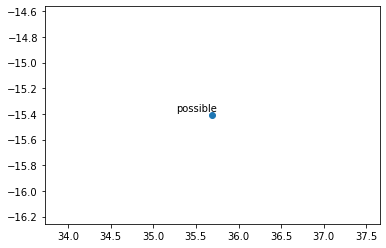

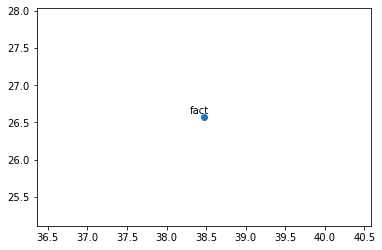

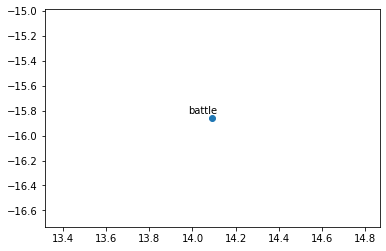

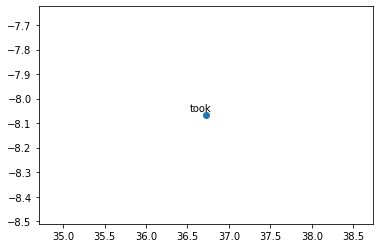

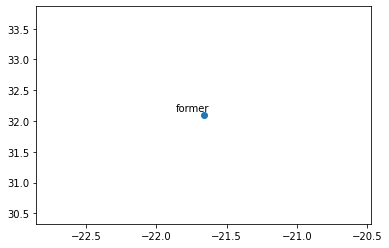

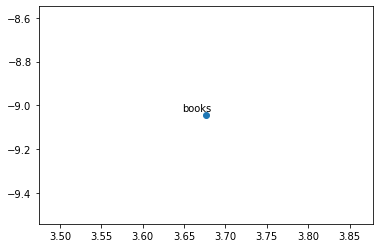

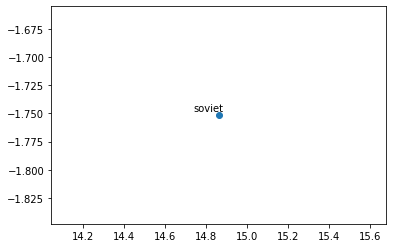

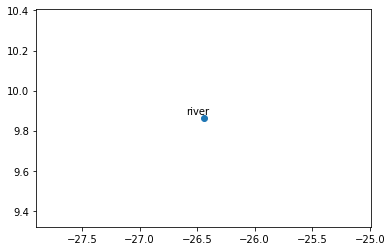

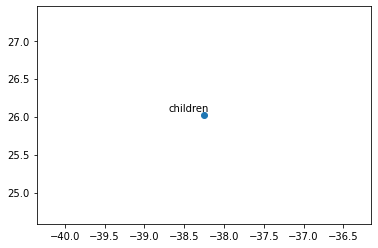

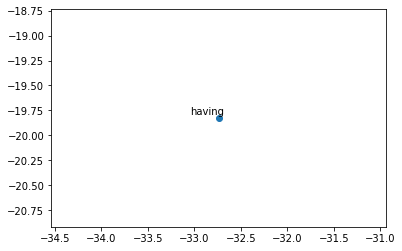

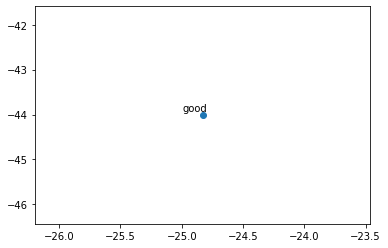

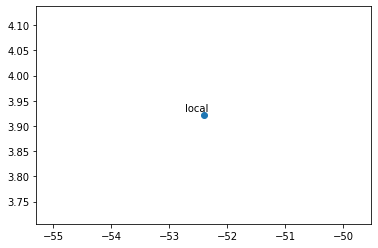

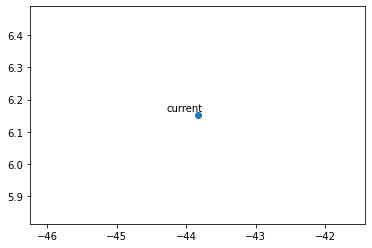

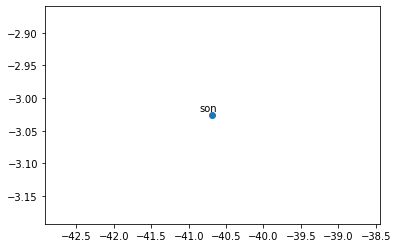

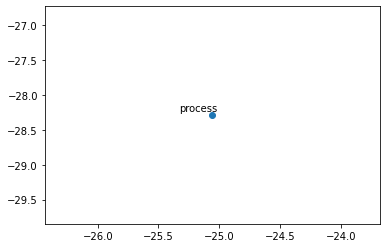

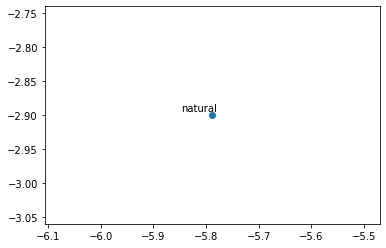

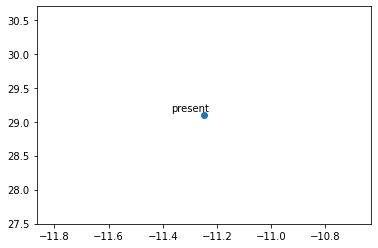

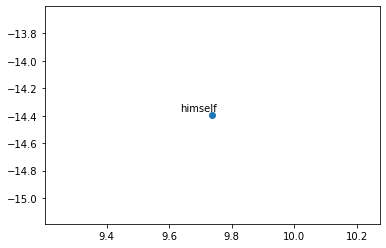

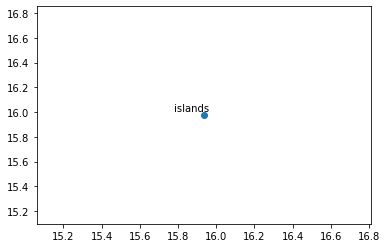

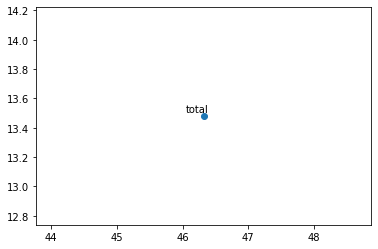

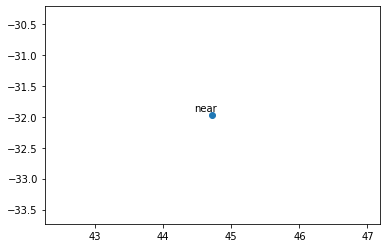

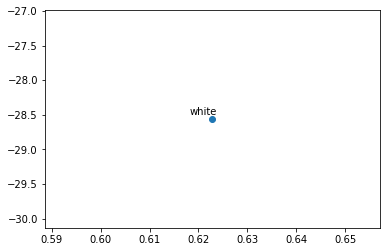

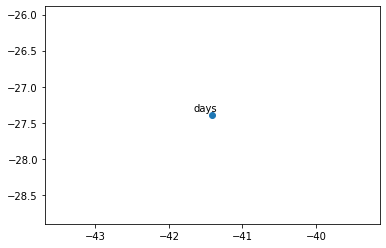

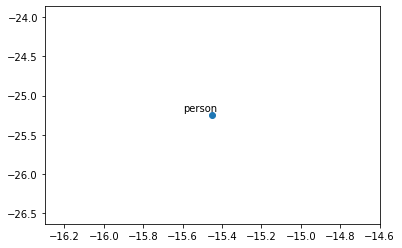

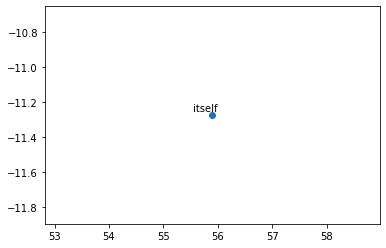

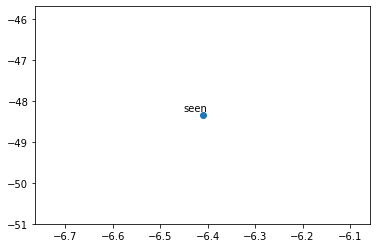

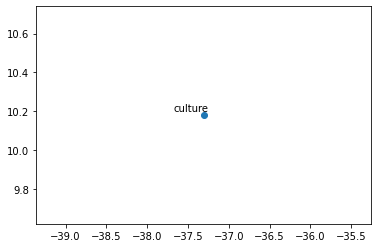

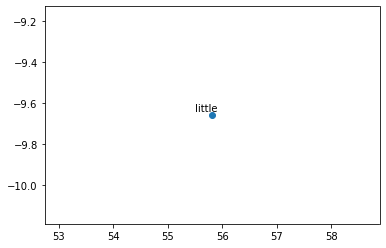

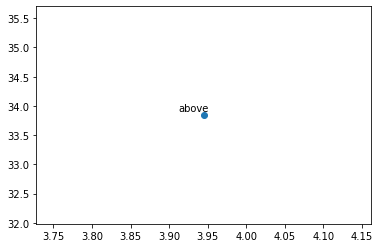

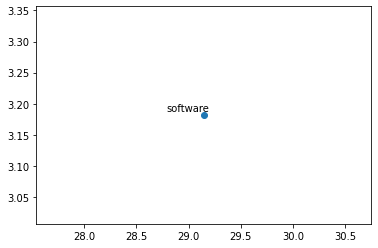

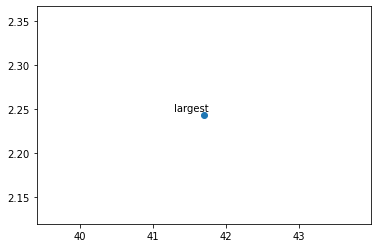

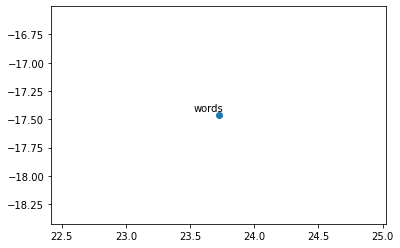

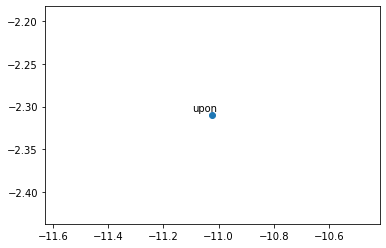

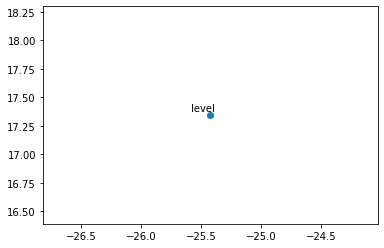

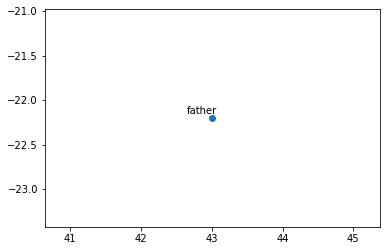

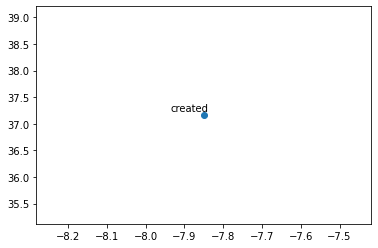

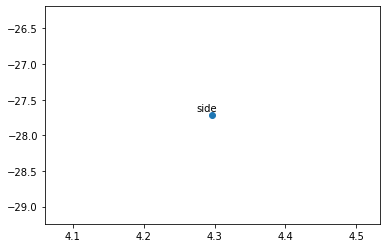

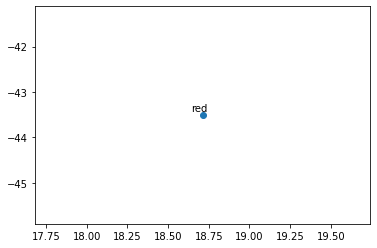

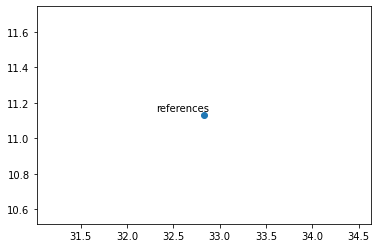

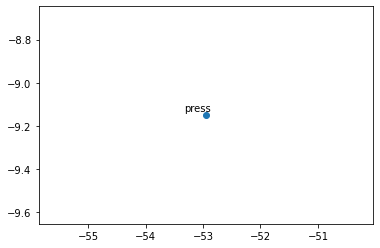

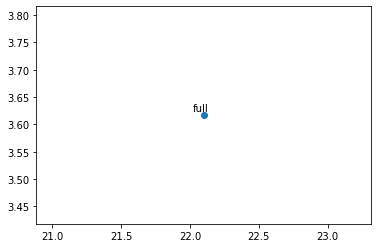

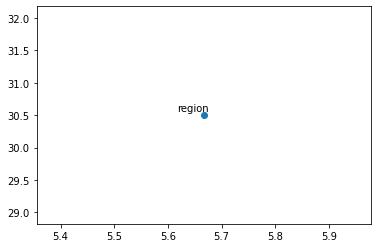

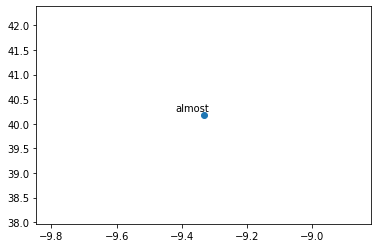

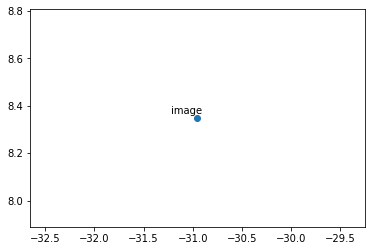

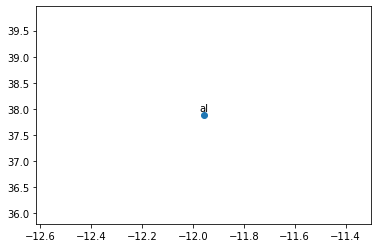

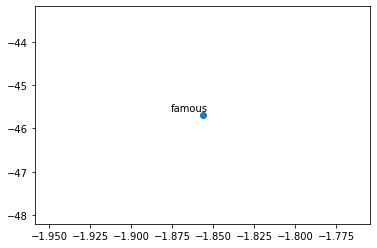

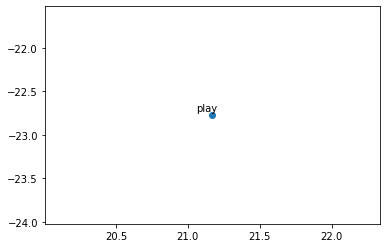

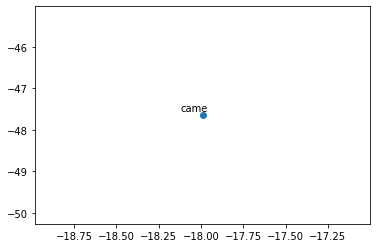

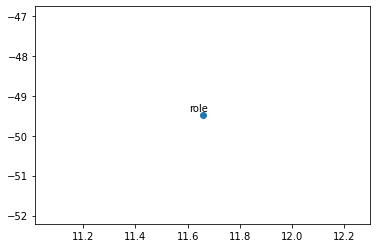

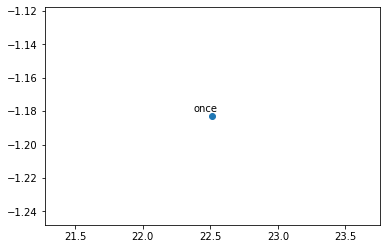

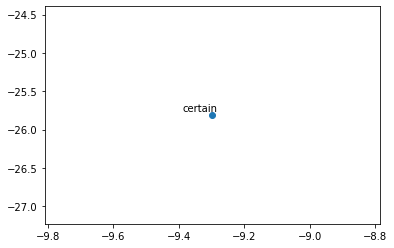

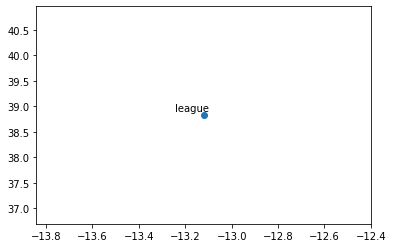

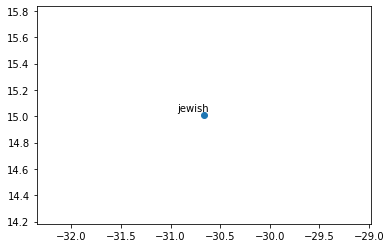

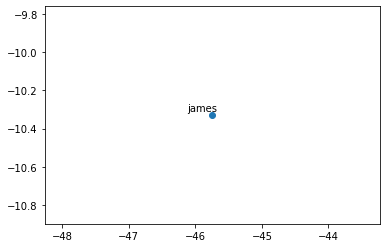

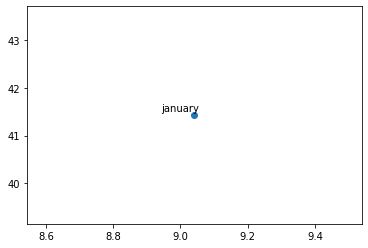

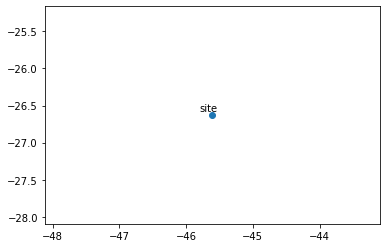

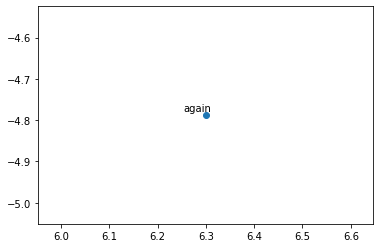

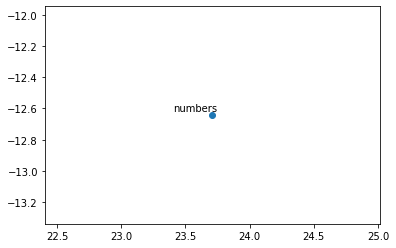

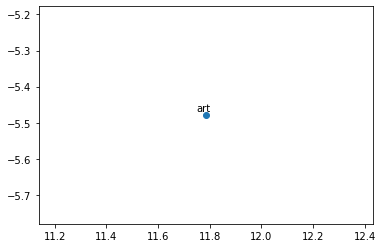

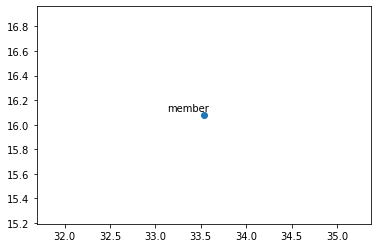

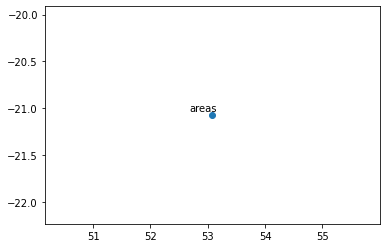

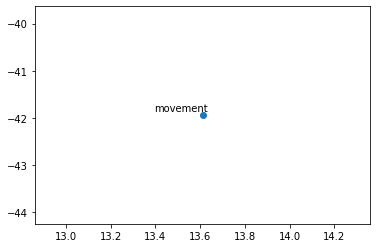

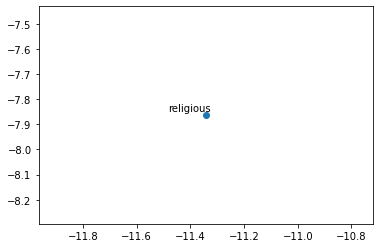

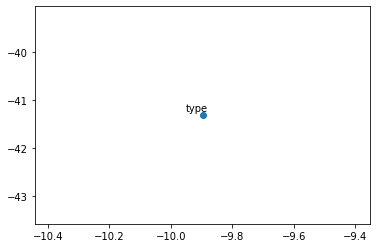

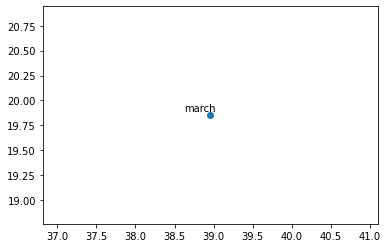

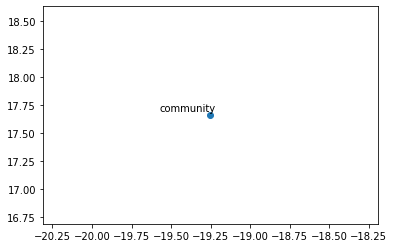

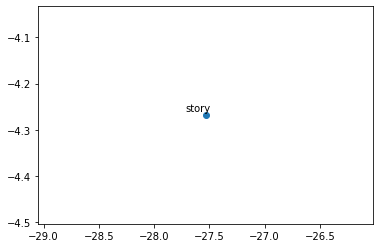

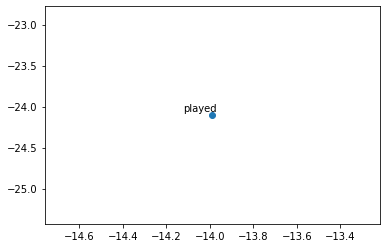

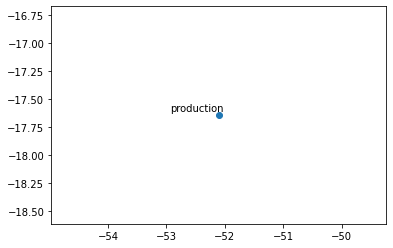

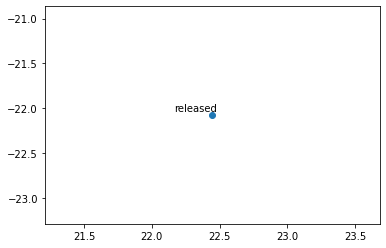

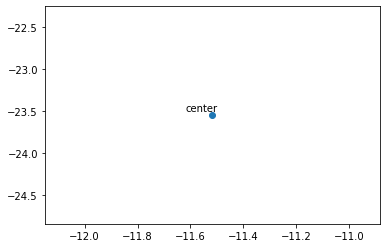

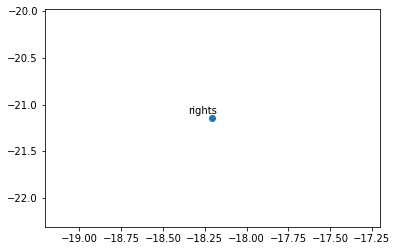

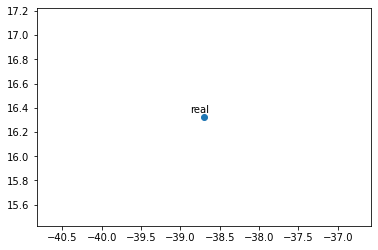

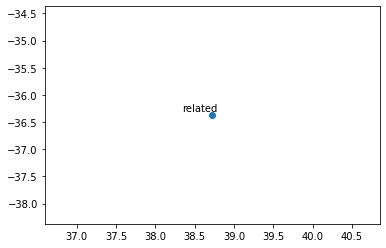

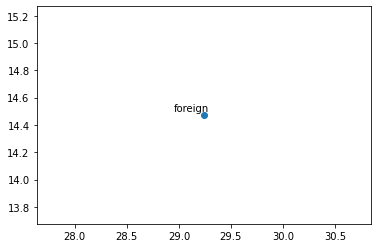

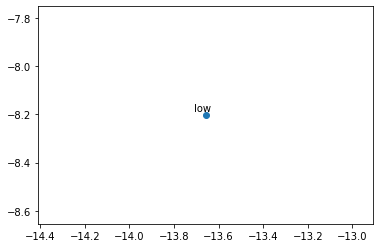

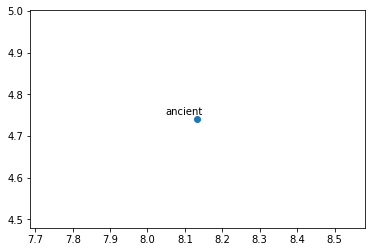

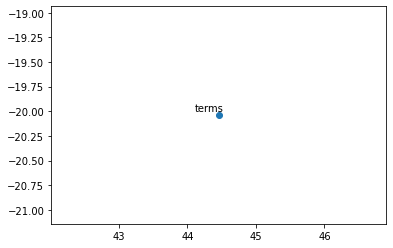

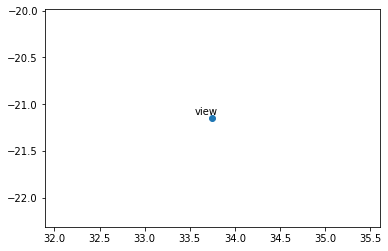

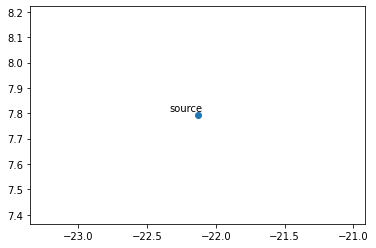

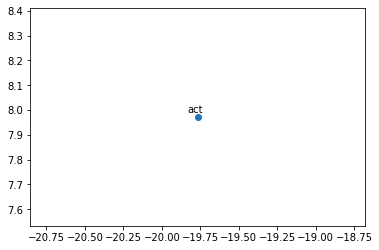

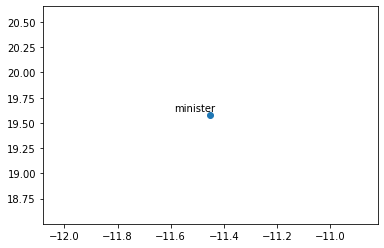

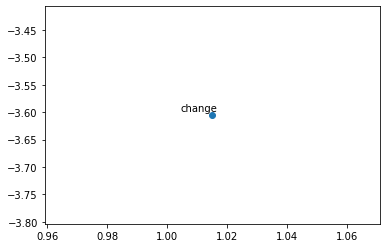

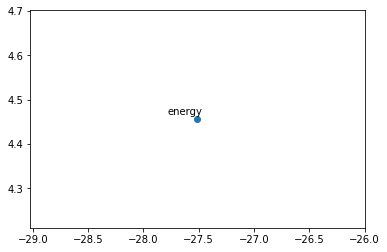

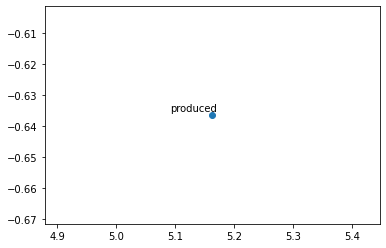

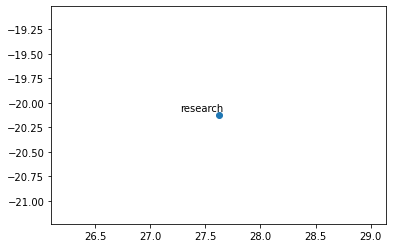

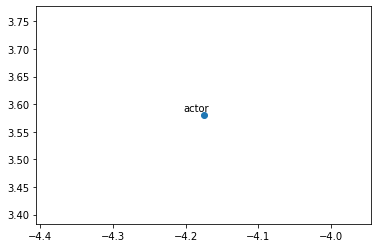

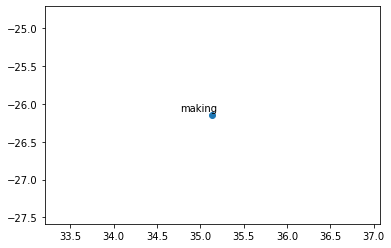

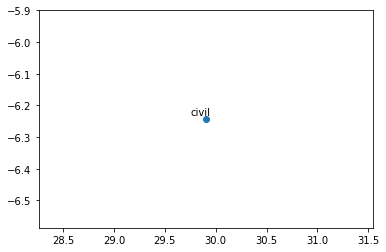

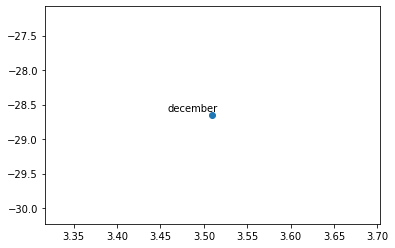

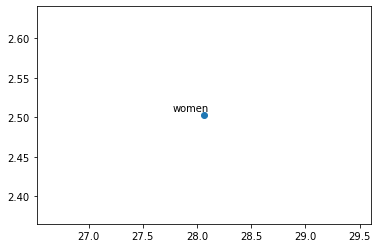

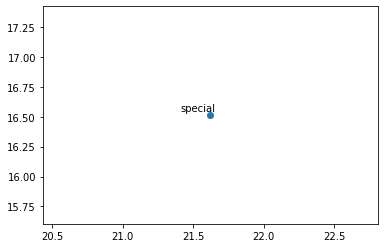

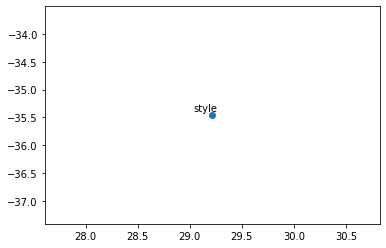

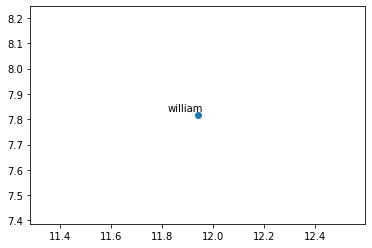

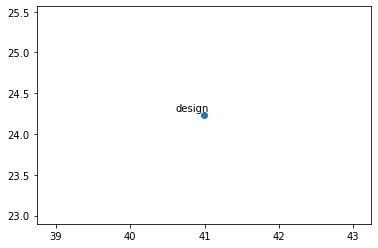

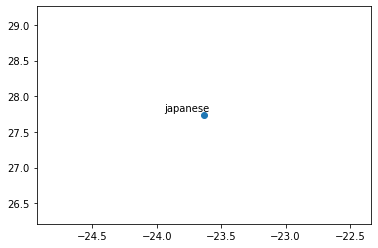

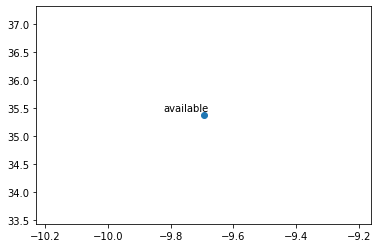

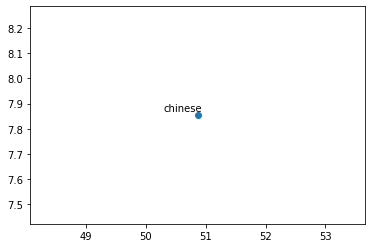

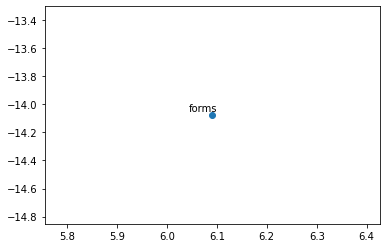

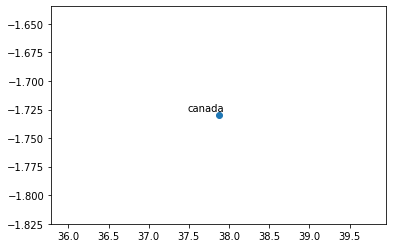

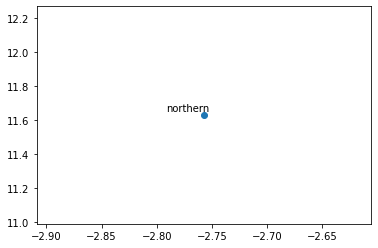

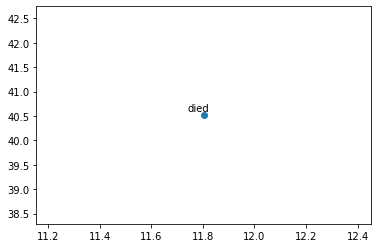

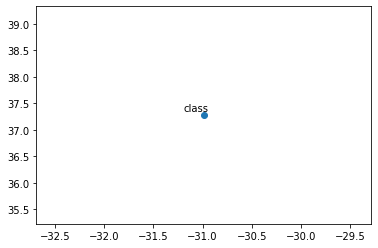

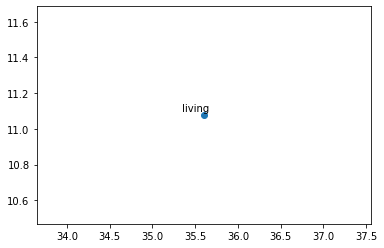

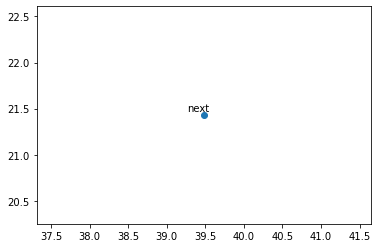

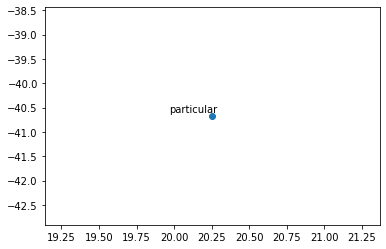

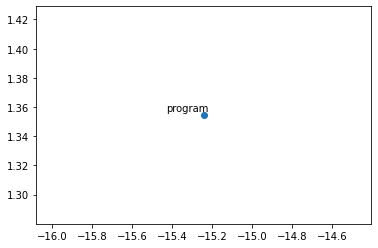

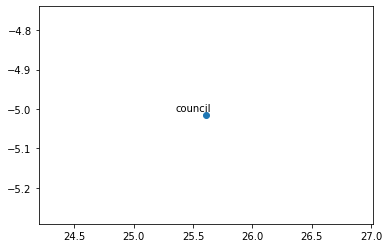

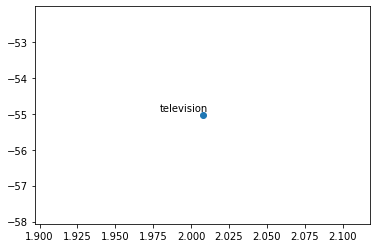

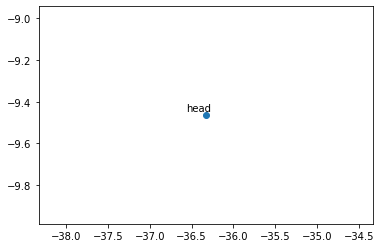

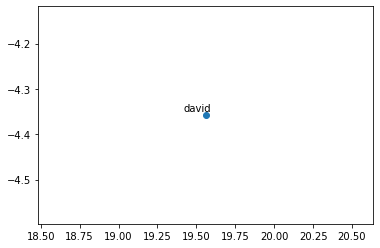

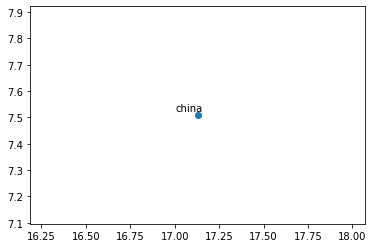

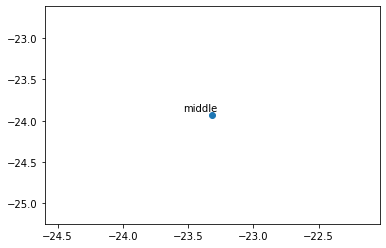

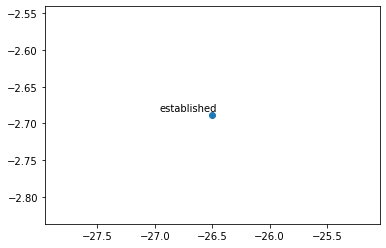

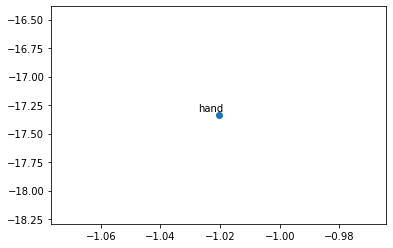

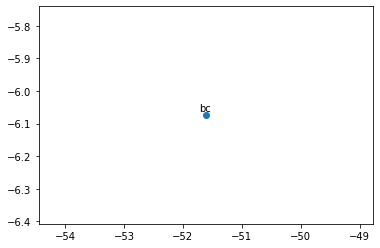

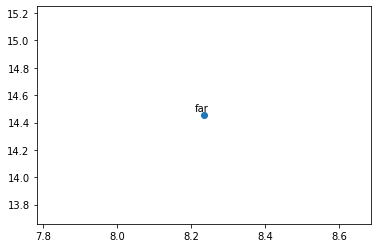

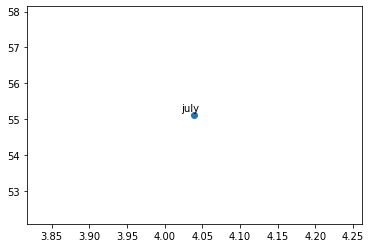

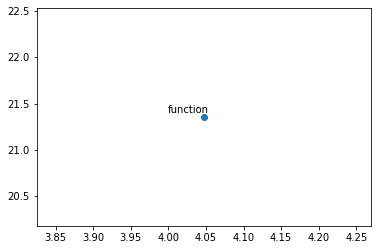

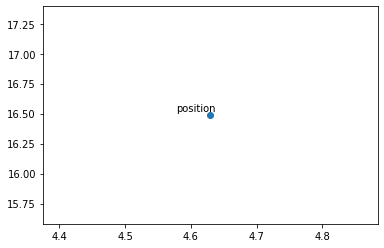

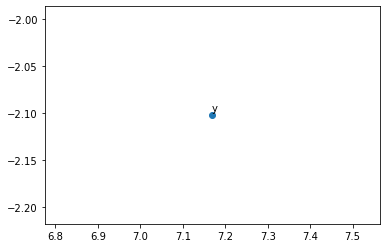

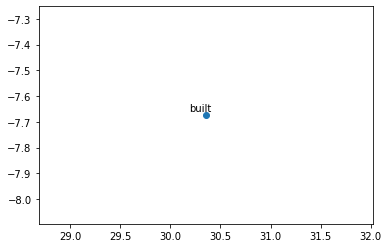

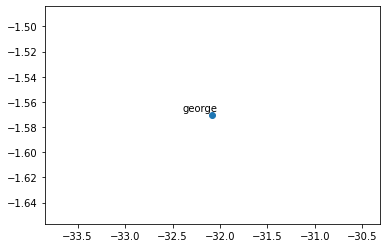

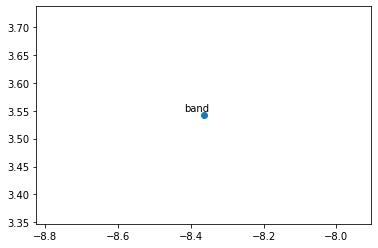

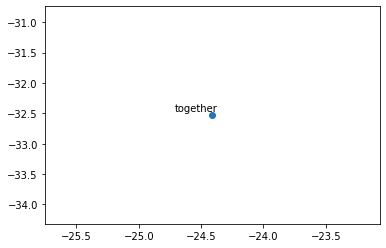

In [131]:
plot_with_labels(low_dim_embs, labels)